# Projecting Food Insecurity Rates in the US by County
## Exploratory Data Analysis
### Flatiron School Data Science Capstone<br>By Khyatee Desai

This capstone project aims to project current & future FI rates at the county level. This means that both **time** and **geography** are important components of understanding the data. The [EDA notebook](notebooks/EDA.ipynb) addresses 3 questions to help gain a better understanding of food insecurity, and how it relates to time, geography, and its closely linked indicators:<br>

**Question 1. How have metrics such as unemployment, houselessness, and food insecurity rates changed over time?**<br>
**Question 2. How do unemployment, race, and food insecurity rates vary geographically?**<br>
**Question 3. What is the relationship between food insecurity rate and other factors such as rent prices, unemployment, houselessness, and race?**


In [1]:
import pandas as pd
import os
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
import warnings
import pickle
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, '../src/')
from functions import *

### Import the cleaned dataset with engineered features

In [2]:
with open('../pickled/feature_engineered_data.pickle', "rb") as input_file:
    df = pickle.load(input_file) 
df.head(2)

,FIPS,Rent,Year,coc_number,Houseless_rate,Sheltered_rate,Unsheltered_rate,State,County,TOT_POP,TOT_MALE,TOT_FEMALE,TOT_WHITE,TOT_BLACK,TOT_NATIVE,TOT_ASIAN,TOT_PACIFIC,TOT_LATINX,State/County,FI Rate,Low Threshold Type,High Threshold Type,Cost Per Meal,Num_wholesale,Num_restaraunts,Num_grocery,Total_workforce,Employed,Unemployed,Unemployment_rate,Percent_male,Percent_female,Percent_white,Percent_Black,Percent_native,Percent_asian,Percent_pacific,Percent_latinX,Percent_PoC,Percent_working,Total_food_retail,Food_retail_per_person,Houseless_rate_X_Sheltered_rate,Rent_X_Percent_Black,Houseless_rate_X_Percent_male,Houseless_rate_X_Percent_female,Rent_X_Percent_working,Sheltered_rate_X_Percent_male,Sheltered_rate_X_Percent_female,Rent_X_Cost Per Meal,Rent_X_Percent_female,Rent_X_Percent_male,Rent_X_Unemployment_rate,Percent_asian_X_Percent_working,Unemployment_rate_X_Percent_Black,Unsheltered_rate_X_Percent_working,Unemployment_rate_X_Percent_white,Unemployment_rate_X_Percent_working,Cost Per Meal_X_Percent_working,Cost Per Meal_X_Percent_asian,Unsheltered_rate_X_Percent_asian,Rent_X_Percent_asian,Sheltered_rate_X_Percent_white,Percent_pacific_X_Percent_working,Percent_Black_X_Percent_working,Unsheltered_rate_X_Percent_male,Unsheltered_rate_X_Percent_female,Rent_X_Food_retail_per_person,Houseless_rate_X_Percent_Black,Cost Per Meal_X_Percent_male,Cost Per Meal_X_Percent_female,Sheltered_rate_X_Percent_Black,Houseless_rate_X_Unemployment_rate,Rent_X_Percent_white,Percent_Black_X_Percent_native,Unemployment_rate_X_Percent_male,Unemployment_rate_X_Percent_female,Unsheltered_rate_X_Cost Per Meal,Percent_Black_X_Percent_pacific,Percent_female_X_Percent_working,Percent_male_X_Percent_working,Cost Per Meal_X_Percent_Black,Percent_white_X_Percent_native,Percent_female_X_Percent_asian,Percent_male_X_Percent_asian,Percent_white_X_Percent_pacific,Sheltered_rate_X_Percent_pacific,Houseless_rate_X_Percent_pacific,Houseless_rate_X_Percent_working,Houseless_rate_X_Percent_asian,TOT_POP_X_Total_food_retail,Num_restaraunts_X_Num_grocery,log_Rent,log_Houseless_rate,log_Sheltered_rate,log_Unsheltered_rate,log_TOT_POP,log_Cost Per Meal,log_Num_wholesale,log_Num_restaraunts,log_Num_grocery,log_Unemployment_rate,log_Percent_male,log_Percent_female,log_Percent_white,log_Percent_Black,log_Percent_native,log_Percent_asian,log_Percent_pacific,log_Percent_working,log_Total_food_retail,log_Food_retail_per_person,Lo_thresh_SNAP,Lo_thresh_SNAP_other,Hi_thresh_SNAP,Hi_thresh_SNAP_other,Hi_thresh_other
0,01073,1019.995960,2014,AL-500,0.001396,0.000961,0.000435,Alabama,Jefferson County,659972.0,312491.0,347481.0,355635.0,284082.0,2029.0,10378.0,347.0,24099.0,"Jefferson County, AL",0.197,SNAP,Other Nutrition Program,2.93,483.0,2693.0,400.0,312131.0,292505.0,19626.0,6.3,0.473491,0.526509,0.538864,0.430446,0.003074,0.015725,0.000526,0.036515,0.461136,0.472946,3576.0,0.005418,0.000001,439.052706,0.000661,0.000735,482.402827,0.000455,0.000506,2988.588162,537.036747,482.959213,6425.974545,0.007437,2.711807,0.000206,3.394842,2.979559,1.385731,0.046074,0.000007,16.039344,0.000518,0.000249,0.203577,0.000206,0.000229,5.526758,0.000601,1.387330,1.542670,0.000414,0.008793,549.638868,0.001323,2.982995,3.317005,0.001274,0.000226,0.249010,0.223936,1.261205,0.001657,0.008279,0.007446,0.000283,5.052135e-07,7.338020e-07,0.000660,0.000022,2.360060e+09,1077200.0,6.927554,-6.574399,-6.947657,-7.740715,13.399953,1.075002,6.180017,7.898411,5.991465,1.840550,-0.747622,-0.641487,-0.618292,-0.842934,-5.784654,-4.152509,-7.550628,-0.748774,8.18200,-5.217953,1,0,0,0,1
19,01117,1229.755051,2014,AL-500,0.001396,0.000961,0.000435,Alabama,Shelby County,206280.0,100304.0,105976.0,174094.0,24247.0,805.0,4403.0,101.0,11872.0,"Shelby County, AL",0.105,SNAP,Other Nutrition Program,3.37,1.0,743.0,2706.0,107208.0,102400.0,4808.0,4.5,0.486252,0.513748,0.843969,0.117544,0.003902,0.021345,0.000490,0.057553,0.156031,0.519721,3450.0,0.016725,0.000001,144.550469,0.000679,0.000717,639.129239,0.000467,0.000494,4

# Inspect the Data
Look at descriptive statistics to get a general understanding of the distribution of each feature

In [3]:
df.describe()

,Rent,Houseless_rate,Sheltered_rate,Unsheltered_rate,TOT_POP,TOT_MALE,TOT_FEMALE,TOT_WHITE,TOT_BLACK,TOT_NATIVE,TOT_ASIAN,TOT_PACIFIC,TOT_LATINX,FI Rate,Cost Per Meal,Num_wholesale,Num_restaraunts,Num_grocery,Total_workforce,Employed,Unemployed,Unemployment_rate,Percent_male,Percent_female,Percent_white,Percent_Black,Percent_native,Percent_asian,Percent_pacific,Percent_latinX,Percent_PoC,Percent_working,Total_food_retail,Food_retail_per_person,Houseless_rate_X_Sheltered_rate,Rent_X_Percent_Black,Houseless_rate_X_Percent_male,Houseless_rate_X_Percent_female,Rent_X_Percent_working,Sheltered_rate_X_Percent_male,Sheltered_rate_X_Percent_female,Rent_X_Cost Per Meal,Rent_X_Percent_female,Rent_X_Percent_male,Rent_X_Unemployment_rate,Percent_asian_X_Percent_working,Unemployment_rate_X_Percent_Black,Unsheltered_rate_X_Percent_working,Unemployment_rate_X_Percent_white,Unemployment_rate_X_Percent_working,Cost Per Meal_X_Percent_working,Cost Per Meal_X_Percent_asian,Unsheltered_rate_X_Percent_asian,Rent_X_Percent_asian,Sheltered_rate_X_Percent_white,Percent_pacific_X_Percent_working,Percent_Black_X_Percent_working,Unsheltered_rate_X_Percent_male,Unsheltered_rate_X_Percent_female,Rent_X_Food_retail_per_person,Houseless_rate_X_Percent_Black,Cost Per Meal_X_Percent_male,Cost Per Meal_X_Percent_female,Sheltered_rate_X_Percent_Black,Houseless_rate_X_Unemployment_rate,Rent_X_Percent_white,Percent_Black_X_Percent_native,Unemployment_rate_X_Percent_male,Unemployment_rate_X_Percent_female,Unsheltered_rate_X_Cost Per Meal,Percent_Black_X_Percent_pacific,Percent_female_X_Percent_working,Percent_male_X_Percent_working,Cost Per Meal_X_Percent_Black,Percent_white_X_Percent_native,Percent_female_X_Percent_asian,Percent_male_X_Percent_asian,Percent_white_X_Percent_pacific,Sheltered_rate_X_Percent_pacific,Houseless_rate_X_Percent_pacific,Houseless_rate_X_Percent_working,Houseless_rate_X_Percent_asian,TOT_POP_X_Total_food_retail,Num_restaraunts_X_Num_grocery,log_Rent,log_Houseless_rate,log_Sheltered_rate,log_Unsheltered_rate,log_TOT_POP,log_Cost Per Meal,log_Num_wholesale,log_Num_restaraunts,log_Num_grocery,log_Unemployment_rate,log_Percent_male,log_Percent_female,log_Percent_white,log_Percent_Black,log_Percent_native,log_Percent_asian,log_Percent_pacific,log_Percent_working,log_Total_food_retail,log_Food_retail_per_person,Lo_thresh_SNAP,Lo_thresh_SNAP_other,Hi_thresh_SNAP,Hi_thresh_SNAP_other,Hi_thresh_other
count,6645.000000,47487.000000,47487.000000,47487.000000,4.805700e+04,4.805700e+04,4.805700e+04,4.805700e+04,4.805700e+04,48057.000000,4.805700e+04,48057.000000,4.805700e+04,38370.000000,38342.000000,21399.000000,21399.000000,21399.000000,8.477800e+04,8.477800e+04,84778.000000,84778.000000,48057.000000,48057.000000,48057.000000,48057.000000,48057.000000,48057.000000,48057.000000,48057.000000,48057.000000,48045.000000,21399.000000,19657.000000,4.748700e+04,3213.000000,47487.000000,47487.000000,3213.000000,47487.000000,47487.000000,1785.000000,3213.000000,3213.000000,6645.000000,48045.000000,48045.000000,47487.000000,48045.000000,48045.000000,35215.000000,35226.000000,4.748700e+04,3213.000000,47487.000000,48045.000000,48045.000000,47487.000000,47487.000000,1240.000000,47487.000000,35226.000000,35226.000000,47487.000000,47487.000000,3213.000000,48057.000000,48045.000000,48045.000000,34821.000000,48057.000000,48045.000000,48045.000000,35226.000000,48057.000000,48057.000000,48057.000000,48057.000000,4.748700e+04,4.748700e+04,47487.000000,47487.000000,1.965700e+04,2.139900e+04,6645.000000,47487.000000,47487.000000,47487.000000,48057.000000,38342.000000,21399.000000,21399.000000,21399.000000,84778.000000,48057.000000,48057.000000,48057.000000,48057.000000,48057.000000,48057.000000,48057.000000,48045.000000,21399.000000,19657.000000,85037.000000,85037.000000,85037.000000,85037.000000,85037.000000
mean,1609.911352,0.001072,0.000669,0.000403,1.243185e+05,6.114445e+04,6.317403e+04,9.483544e+04,1.662157e+04,1527.897226,7.884455e+03,287.311880,2.510092e+04,0.14729

From the statistics above, we see that most features, such as Rent, Unemployment_rate, and Total_food_retail contain large upper outliers. 
## Visualize Outliers

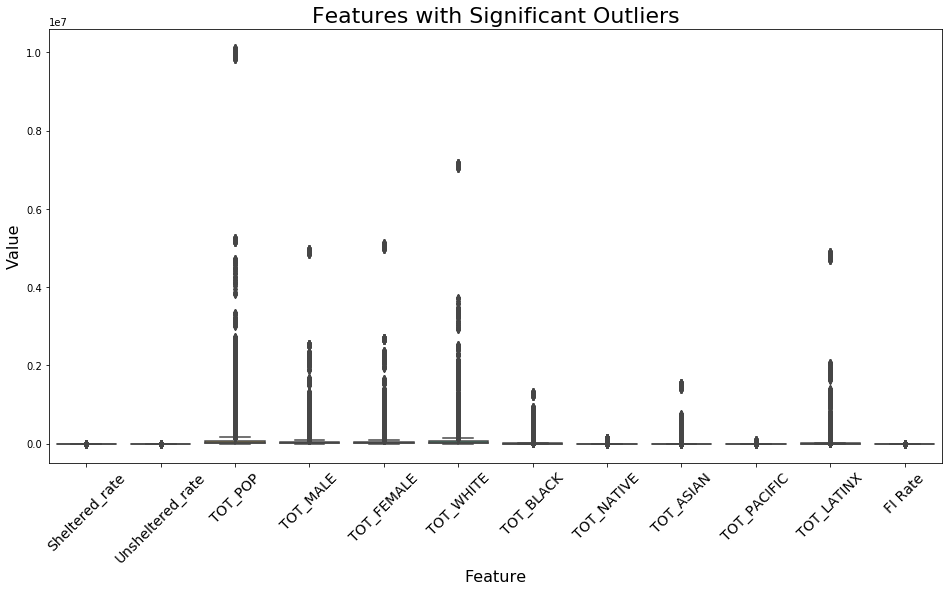

In [4]:
# create boxplot for each feature with larger outliers
plt.figure(figsize=(16, 8));
sns.boxplot(data= df.iloc[:,5:22]);
plt.title('Features with Significant Outliers', fontdict={'fontsize':22});
plt.ylabel('Value', fontdict={'fontsize':16});
plt.xlabel('Feature', fontdict={'fontsize':16});
plt.xticks(rotation=45,fontsize=14);
plt.savefig('../images/box_outliers.png',format = 'png',bbox_inches='tight', transparent=True)

The above boxplots illustrate that TOT_POP, TOT_MALE, TOT_FEMALE, TOT_WHITE, TOT_BLACK, TOT_ASIAN, AND TOT_LATINX in particular have very large outliers that will likely need to be reduced during the modeling process to improve model generalizability.
## Multicollinearity
Inspect multicollinearity using a heatmap to determine which features are highly correlated and can potentially be removed during the modeling process

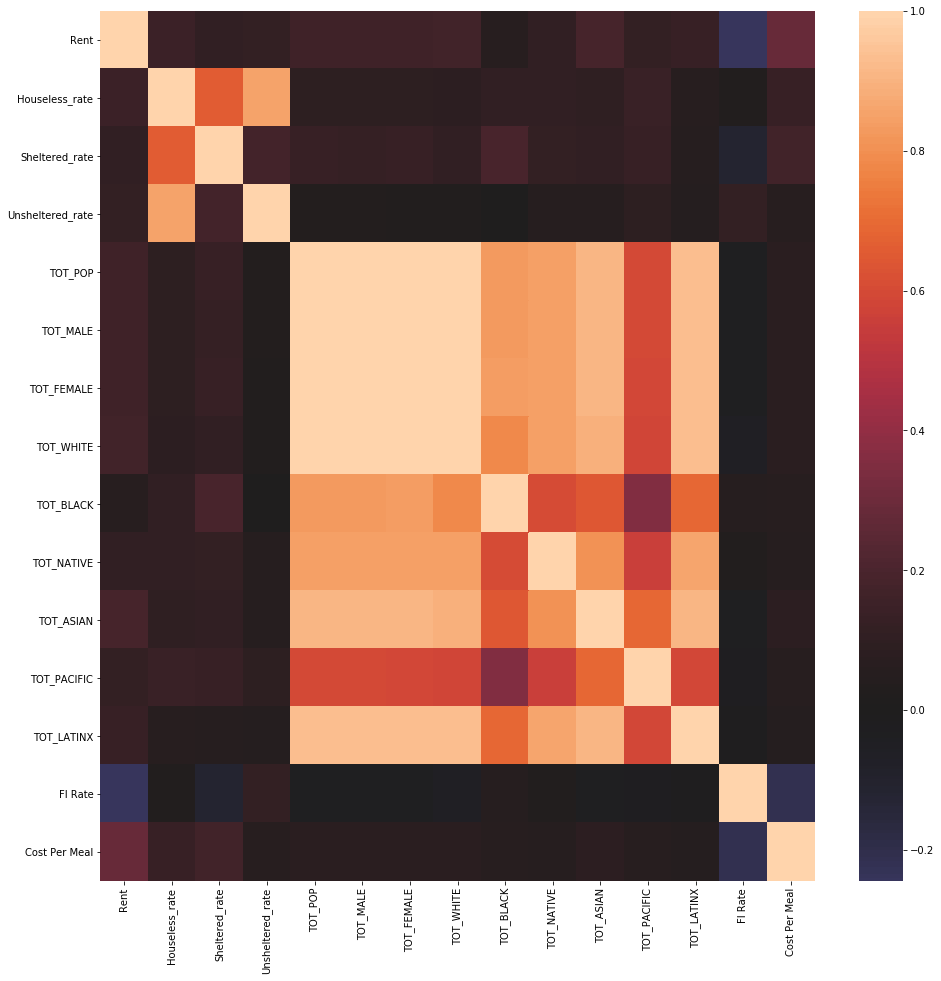

In [5]:
# generate a heatmap of correlation matrix for original dataset features 
plt.figure(figsize=(16, 16));
sns.heatmap(df.iloc[:,:23].corr(), center=0);
plt.savefig('../images/heat_multicoll.png',format = 'png',bbox_inches='tight', transparent=True)

The above heatmap indicates that is very high correlation between all pairs of demographic features, such as TOT_NATIVE and TOT_ASIAN. This makes sense, given that a place with a higher overall population likely contains a higher presence of all demographics, than a place with a low total population.<br>

There is also high collinearity between houseless_rate, sheltered_rate, and unsheltered_rate, which makes sense as they are all directly related to one another.<br>

Highly correlated features may be removed during the modeling process based on model performance and interpretability.

# Question 1: How have features changed over time?
The first EDA question explores how different features from the original dataset have changed over time. Because this project ultimately aims to project food insecurity rates for 2020, it is important to get an understanding of how features change over time, and whether they follow any discernable trends.<br>

Each feature group is scaled to the same magnitude, and visualized using lineplots or/and barcharts. The productions of these charts with multiple variables is accomplished using two functions: `lineplot()` and `barchart()`, both of which can be found in the src folder of this repository.

## Food Insecurity, Houselessness, and Unemployment Rates, by Year
The charts below aim to visualize and compare the trends between these three scaled features over time:

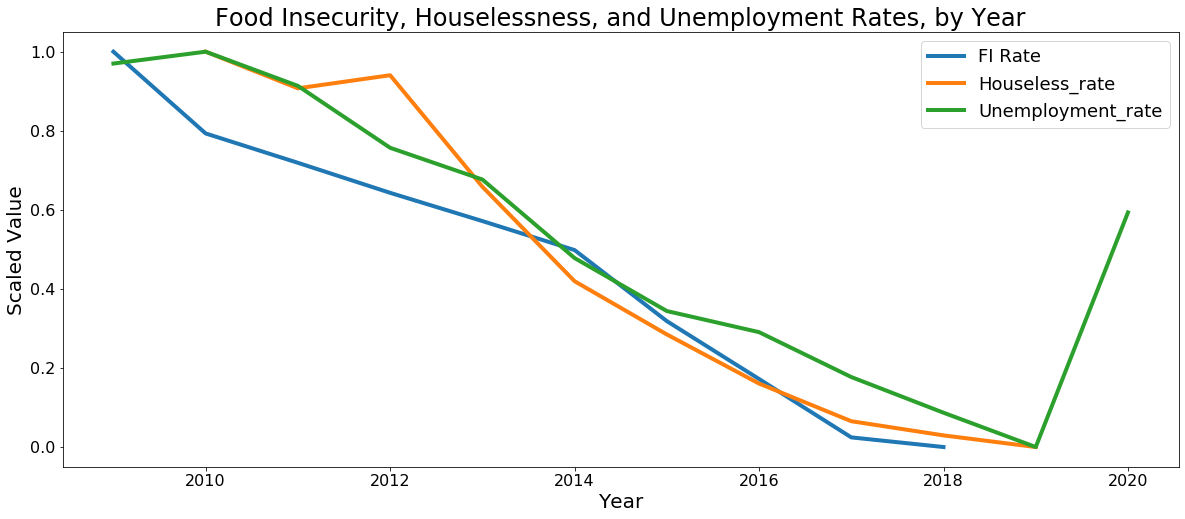

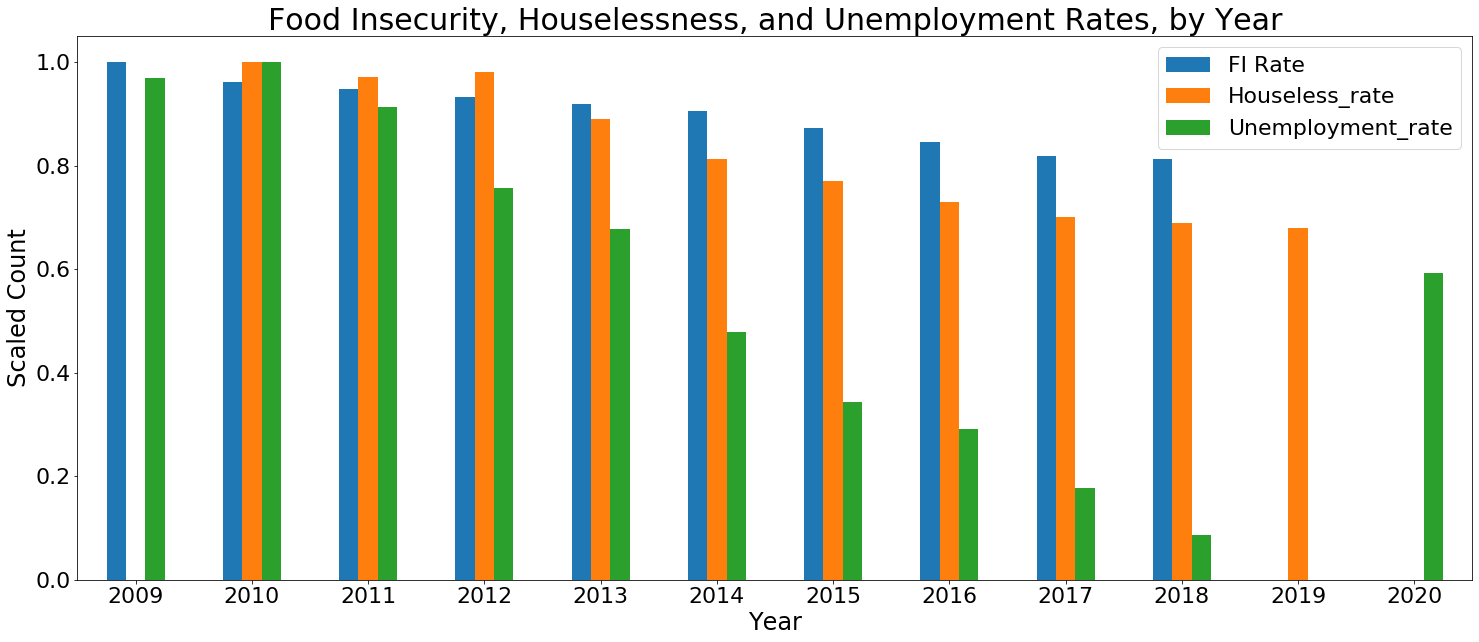

In [4]:
lineplot(df, ['FI Rate','Houseless_rate','Unemployment_rate'], title='Food Insecurity, Houselessness, and Unemployment Rates, by Year')
barchart(df, ['FI Rate','Houseless_rate','Unemployment_rate'], title='Food Insecurity, Houselessness, and Unemployment Rates, by Year')


The lineplot and barcharts above indicate there is a visible correlation between FI rate (target variable,) unemployment, and houseless rates. This is important to keep in mind, moving into modeling and inspecting feature importance.
## Food Retail by Year
This chart aims to visualize and compare the trends of number of grocery stores, restaraunts, and wholesalers by year.

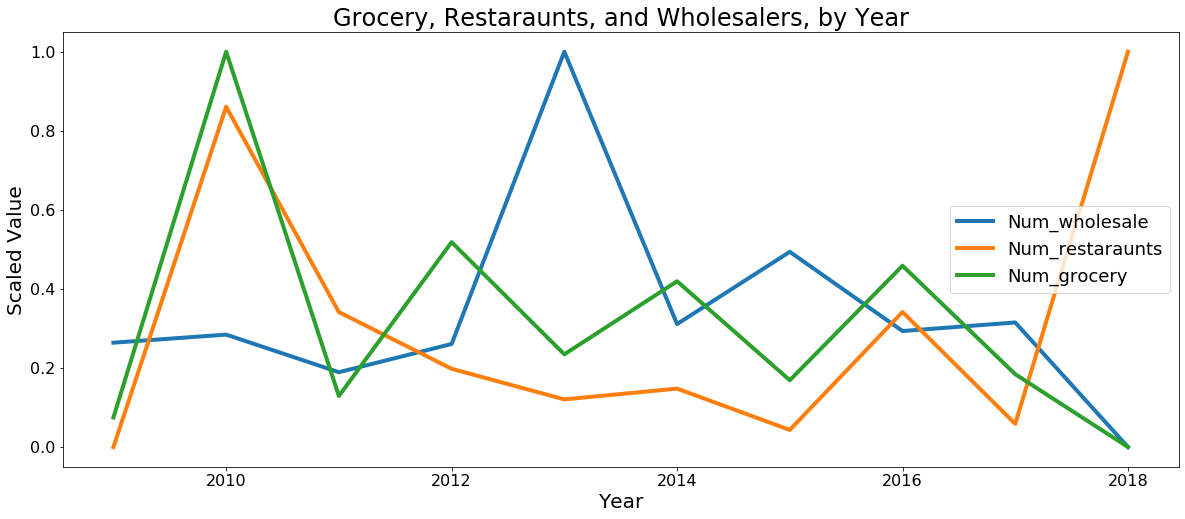

In [9]:
features = ['Num_wholesale','Num_restaraunts', 'Num_grocery']
lineplot(df, features ,title='Grocery, Restaraunts, and Wholesalers, by Year')

Overall there is surprisingly not a significant trend in the linecharts above on number of food retail businesses, however it is noteable that the year 2018 shows a sharp increase in the average number of restaraunts, and a decrease in the number of wholesalers and grocery stores. Generally buying food from restaraunts is more expensive per meal, than buying food from a grocery store, which could indicate that more people were getting food from restaraunts in 2018.
## Rent and Meal Cost, by Year
These charts aim to visualize and compare how rent prices and food costs have changed by year. Rent data was available starting in 2014, and extends into 2020, while meal cost data was available from 2009 to 2018.

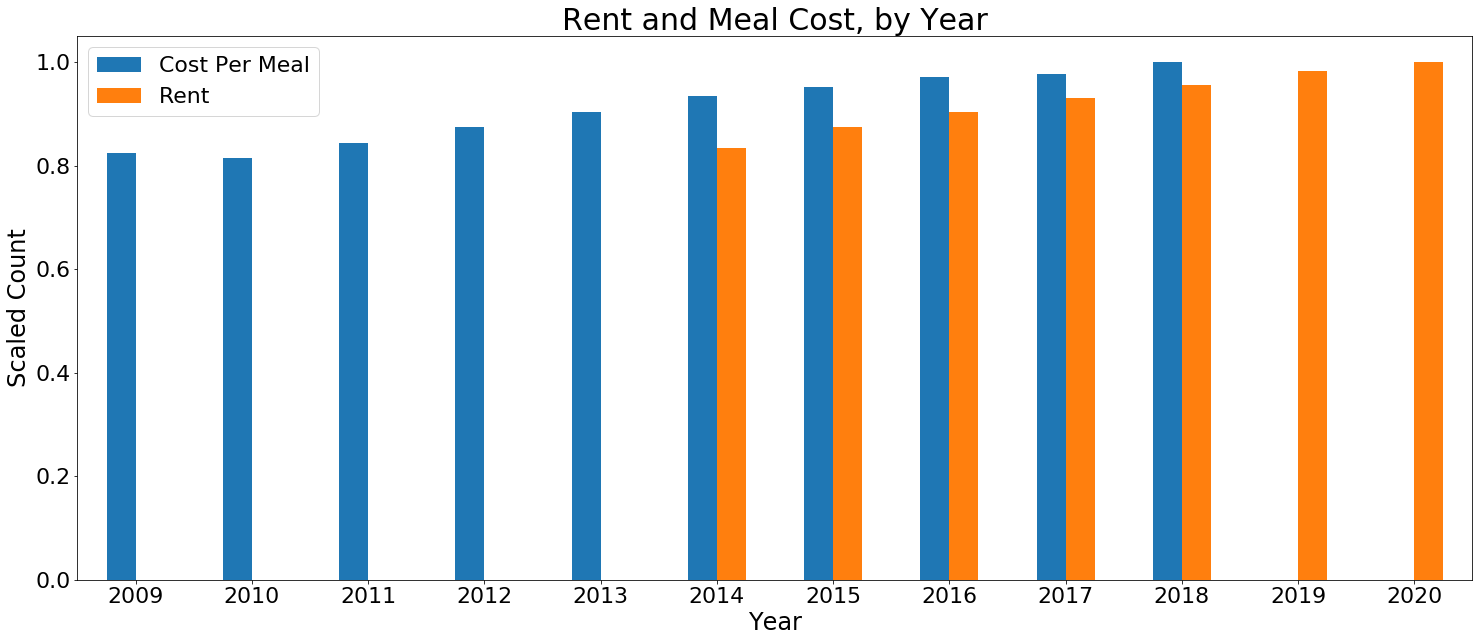

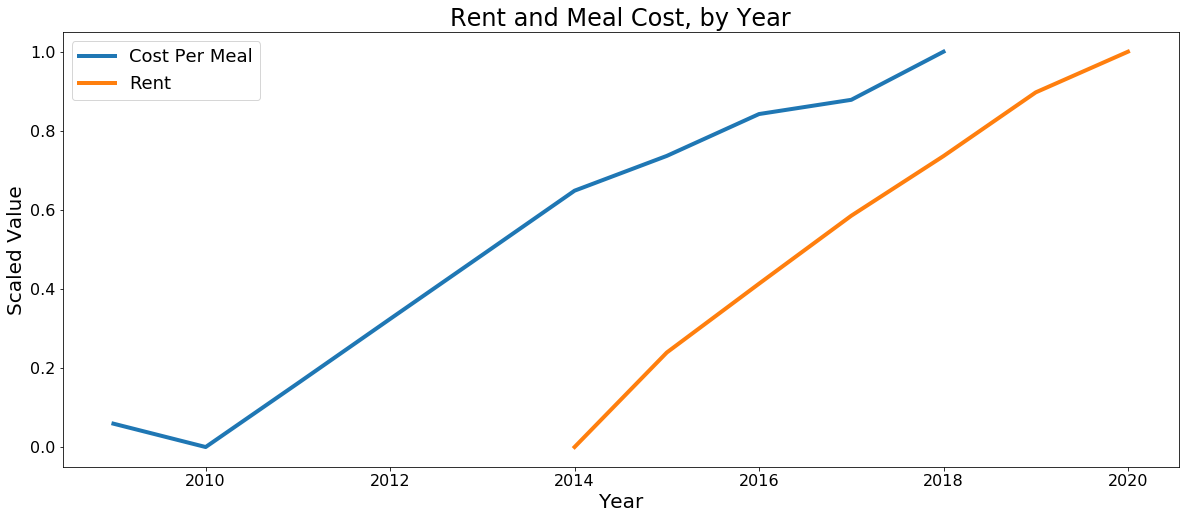

In [10]:
barchart(df, ['Cost Per Meal','Rent'], title='Rent and Meal Cost, by Year')
lineplot(df, ['Cost Per Meal','Rent'],title='Rent and Meal Cost, by Year')


The charts above that there is a clear positive relationship over time between average food cost and rent prices. This is interesting to note, considering the charts above, which show FI rates, houselessness, and unemployment trending downwards over time. 
## Food Insecurity in Different Communities, by Year
The following lineplots aim to look at how average food insecurity rates differ accross different racial communities over time:

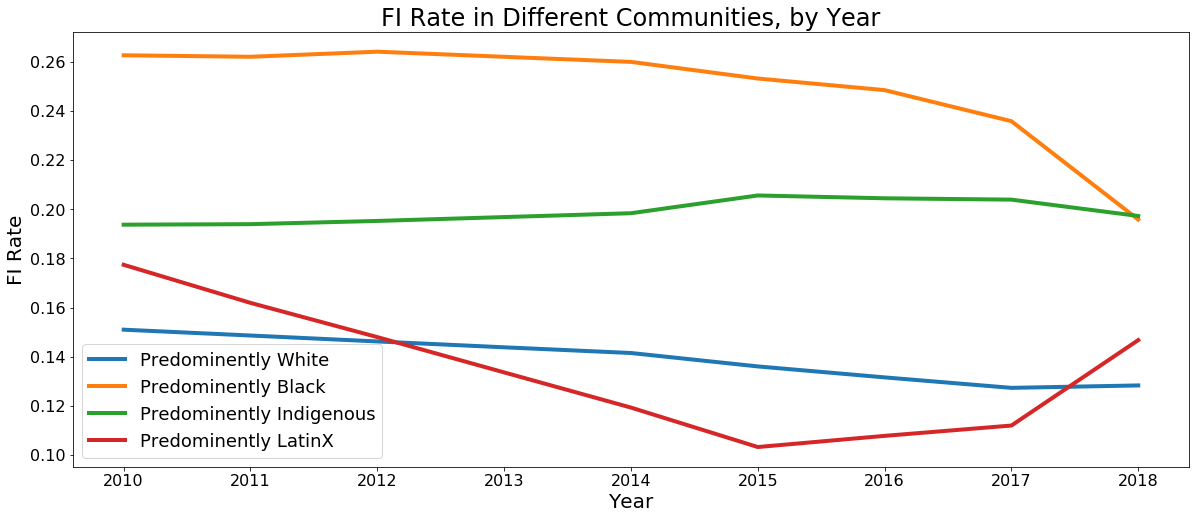

In [11]:
# create dataframe for each race where populalation is predominently that race, and group by year
wyt = df[['FI Rate','Year']][df['Percent_white']>.5].groupby('Year').mean()
poc = df[['FI Rate','Year']][df['Percent_white']<.5].groupby('Year').mean()
blck = df[['FI Rate','Year']][df['Percent_Black']>.5].groupby('Year').mean()
native = df[['FI Rate','Year']][df['Percent_native']>.5].groupby('Year').mean()
latinx = df[['FI Rate','Year']][df['Percent_latinX']>.5].groupby('Year').mean()
asian = df[['FI Rate','Year']][df['Percent_asian']>.4].groupby('Year').mean()

# plot each df in a lineplot
plt.figure(figsize=(20, 8));
ax =sns.lineplot(x= wyt.index, y= wyt['FI Rate'], label='Predominently White',linewidth = 4);
ax =sns.lineplot(x= blck.index, y= blck['FI Rate'], label='Predominently Black',linewidth = 4);
# ax =sns.lineplot(x= poc.index, y= poc['FI Rate'], label="All Communities of Color",linewidth = 4);
ax =sns.lineplot(x= native.index, y= native['FI Rate'], label='Predominently Indigenous',linewidth = 4);
ax =sns.lineplot(x= latinx.index, y= latinx['FI Rate'], label='Predominently LatinX',linewidth = 4);
# ax =sns.lineplot(x= asian.index, y= asian['FI Rate'], label='Predominently Asian',linewidth = 4);

ax.set_title("FI Rate in Different Communities, by Year", fontsize=24);
ax.set_ylabel('FI Rate', fontsize=20);
ax.set_xlabel('Year', fontsize=20);
ax.legend(prop=dict(size=18));
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
# plt.savefig('../images/line_FI_race.png',format = 'png',bbox_inches='tight', transparent=True)

The above lineplots indicate that average FI rates are highest in Black communities, followed by Indigenous and LatinX. While the general trend is downwards, some communities encounter anomalous movement, such as predominantly LatinX communities, which face an upward spike in FI Rates moving into 2018. It is important to note that these rates are not directly tied to racial groups, but rather counties with different predominant racial demographics.
### Average Unemployment Rates in Different Communities, by Year
The below cell performs the same process as above, this time looking at average Unemployment rates in different racial communities, by year.

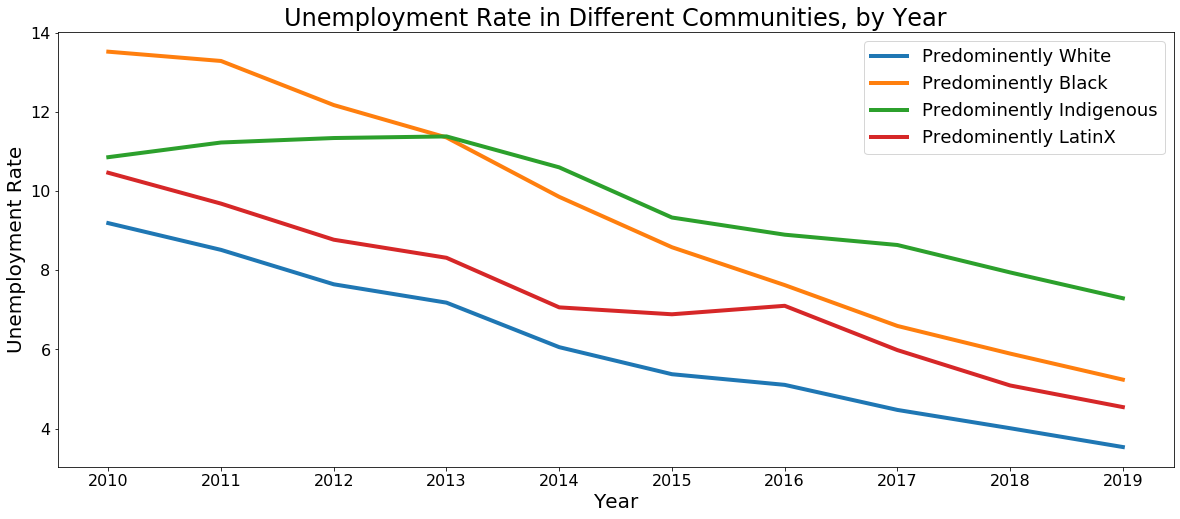

In [12]:
# create dataframe for each race where populalation is predominently that race, and group by year
wyt = df[['Unemployment_rate','Year']][df['Percent_white']>.5].groupby('Year').mean()
poc = df[['Unemployment_rate','Year']][df['Percent_white']<.5].groupby('Year').mean()
blck = df[['Unemployment_rate','Year']][df['Percent_Black']>.5].groupby('Year').mean()
native = df[['Unemployment_rate','Year']][df['Percent_native']>.5].groupby('Year').mean()
latinx = df[['Unemployment_rate','Year']][df['Percent_latinX']>.5].groupby('Year').mean()
asian = df[['Unemployment_rate','Year']][df['Percent_asian']>.4].groupby('Year').mean()

# plot each df in a lineplot
plt.figure(figsize=(20, 8));
ax =sns.lineplot(x= wyt.index, y= wyt['Unemployment_rate'], label='Predominently White',linewidth = 4);
ax =sns.lineplot(x= blck.index, y= blck['Unemployment_rate'], label='Predominently Black',linewidth = 4);
# ax =sns.lineplot(x= poc.index, y= poc['Unemployment_rate'], label="All Communities of Color",linewidth = 4);
ax =sns.lineplot(x= native.index, y= native['Unemployment_rate'], label='Predominently Indigenous',linewidth = 4);
ax =sns.lineplot(x= latinx.index, y= latinx['Unemployment_rate'], label='Predominently LatinX',linewidth = 4);
# ax =sns.lineplot(x= asian.index, y= asian['Unemployment_rate'], label='Predominently Asian',linewidth = 4);

ax.set_title("Unemployment Rate in Different Communities, by Year", fontsize=24);
ax.set_ylabel('Unemployment Rate', fontsize=20);
ax.set_xlabel('Year', fontsize=20);
ax.legend(prop=dict(size=18));
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
# plt.savefig('../images/line_unemp_race.png',format = 'png',bbox_inches='tight', transparent=True)

The above linecharts indicate that predominantly Black and Indigenous communities face higher average rates of unemployment, followed by LatinX communities. The general trend of average unemployment rate is downwards over time.

# Question 2: Which geographic areas have the highest rates of unemployment, houselessness, food insecurity?
The purpose of exploring this question is to gain a better understanding of the geographic component of food insecurity and related features.

## Heatmap
Create a heatmap to get a quick visualization of food insecurity rates in 5 random counties

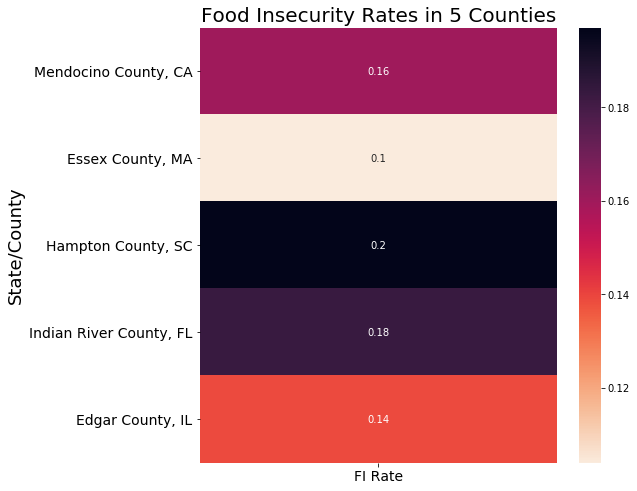

In [13]:
# Create dataframe of 5 random cities
a = df.set_index('State/County')[['FI Rate']].dropna().sample(5)

# make heatmap with most variant features
plt.figure(figsize=(8, 8));
plt.title('Food Insecurity Rates in 5 Counties', fontsize=20);
ax.set_ylim(-20, 20);
plt.xlabel('FI Rate', fontdict={'fontsize':18});
plt.ylabel('County', fontdict={'fontsize':18});
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
sns.heatmap(a, annot=True, cmap='rocket_r');
# plt.savefig('../images/FI_heatmap.png',format = 'png',bbox_inches='tight', transparent=True)

The above heatmap indicates that there is a geographic component in determining food insecurity rates, given that different Counties are shown above to have significant differences in FI Rates.

## Choropleth Maps
The following cells generate chroropleth maps, which are heatmaps that visualize a particular feature across a geographic area. The maps are generated using a function called `choropleth()` which takes a dataframe, feature, year, color palette, and title, and generates a choropleth map.


### Unsheltered Rate by County, 2010 and 2019

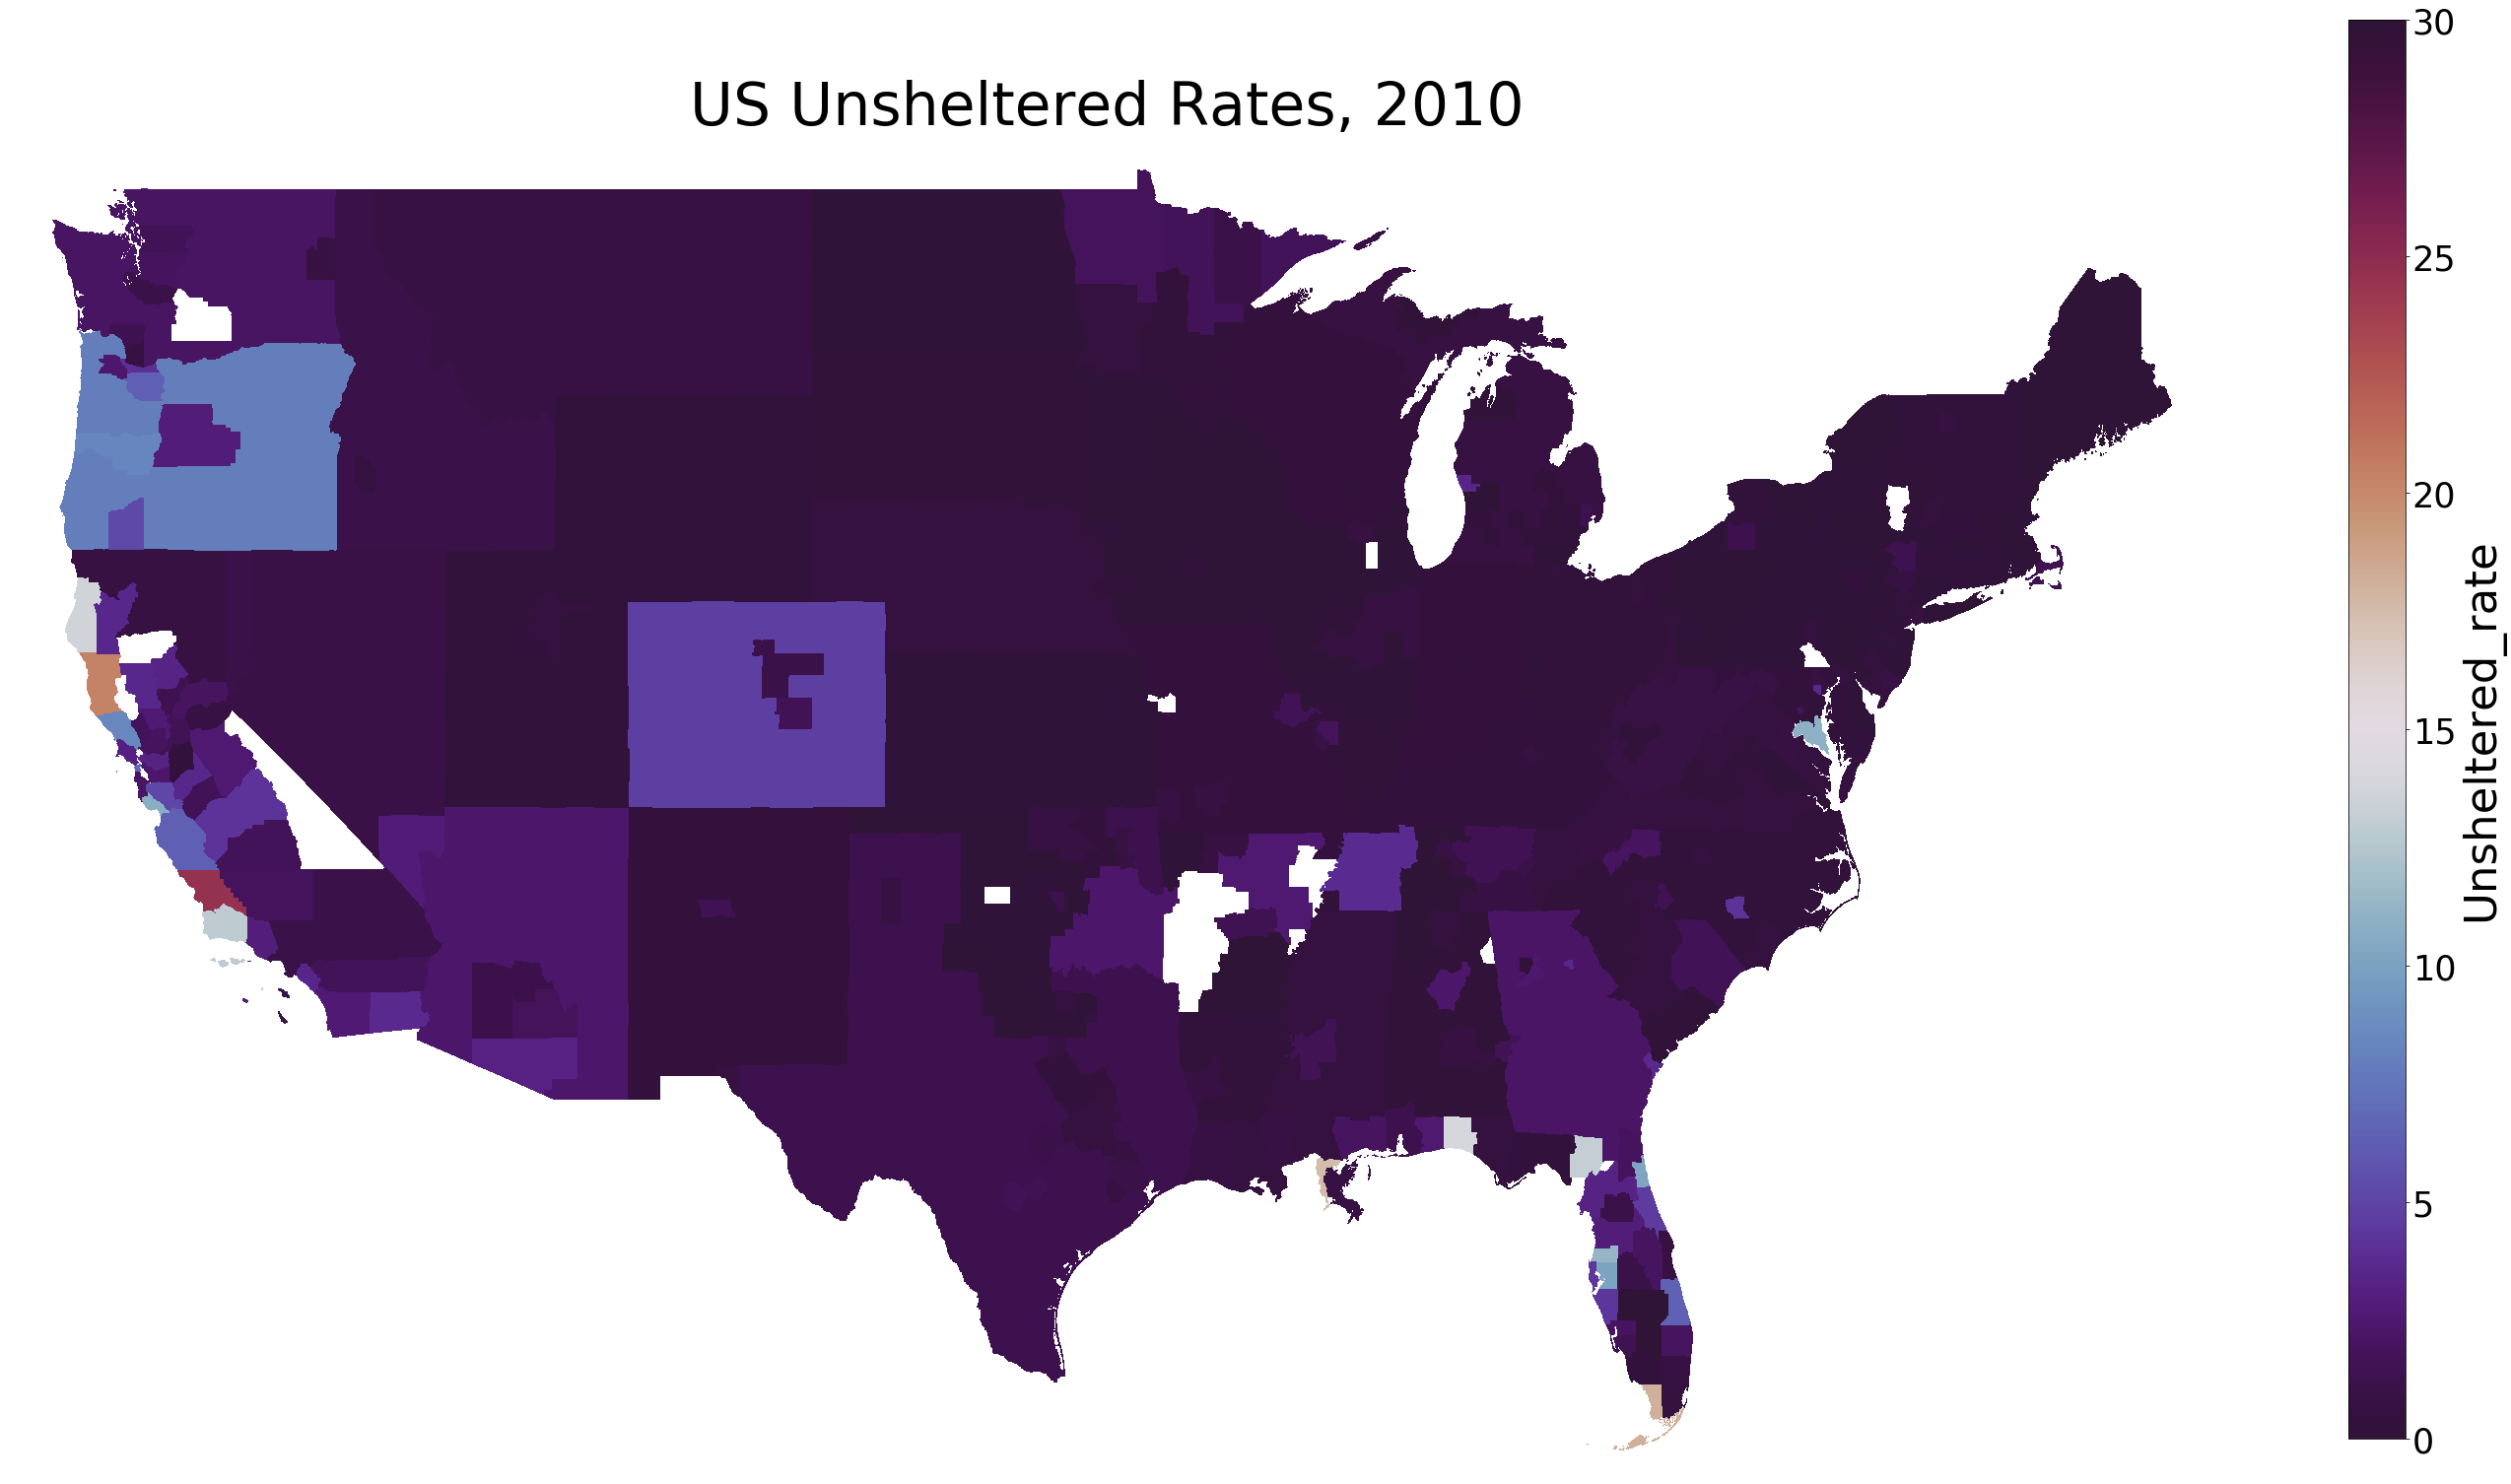

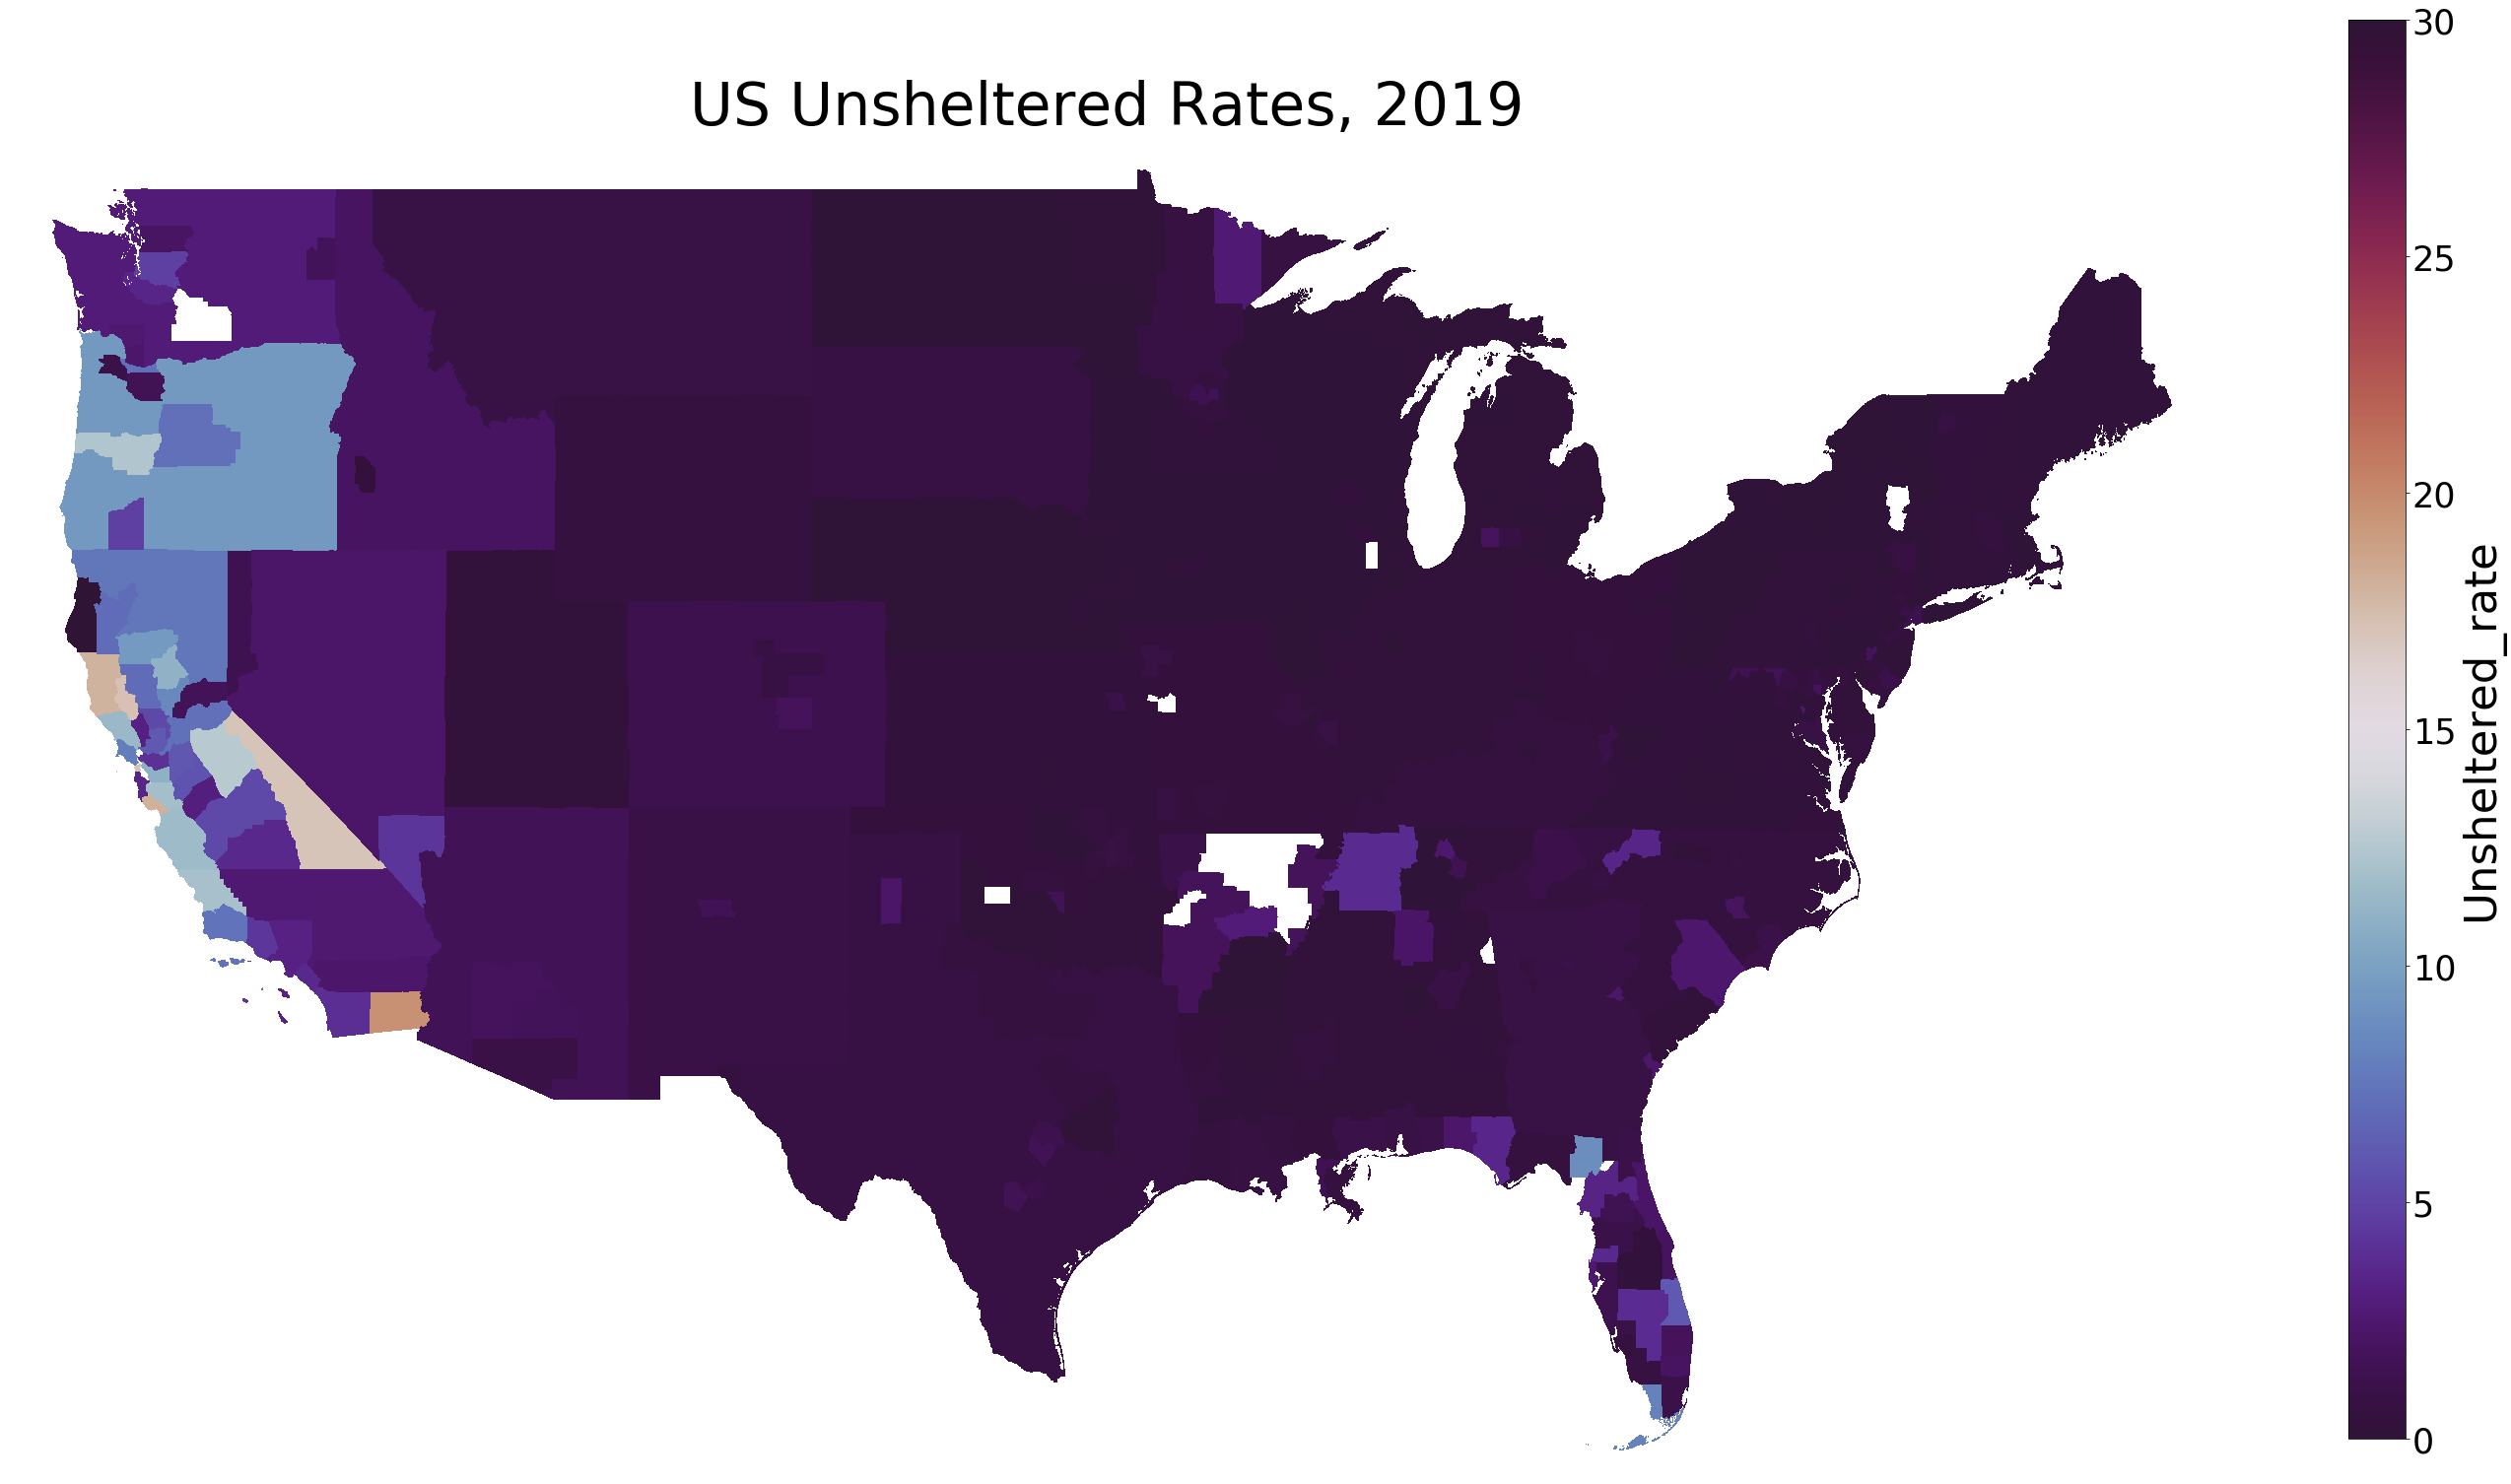

In [3]:
choropleth(df, 'Unsheltered_rate', '2010', "twilight_shifted", 'US Unsheltered Rates')
choropleth(df, 'Unsheltered_rate', '2019', 'twilight_shifted', 'US Unsheltered Rates')

The above maps visualize unsheltered rates, which represent the proportion of a population that is both houseless and unsheltered. The maps indicate that unsheltered rates have decreased in areas through the middle and South of the country, such as some counties in Florida, yet they have *drastically* increased across the West Coast, especially in California.
### Unemployment Rate, by County, 2019 and 2020

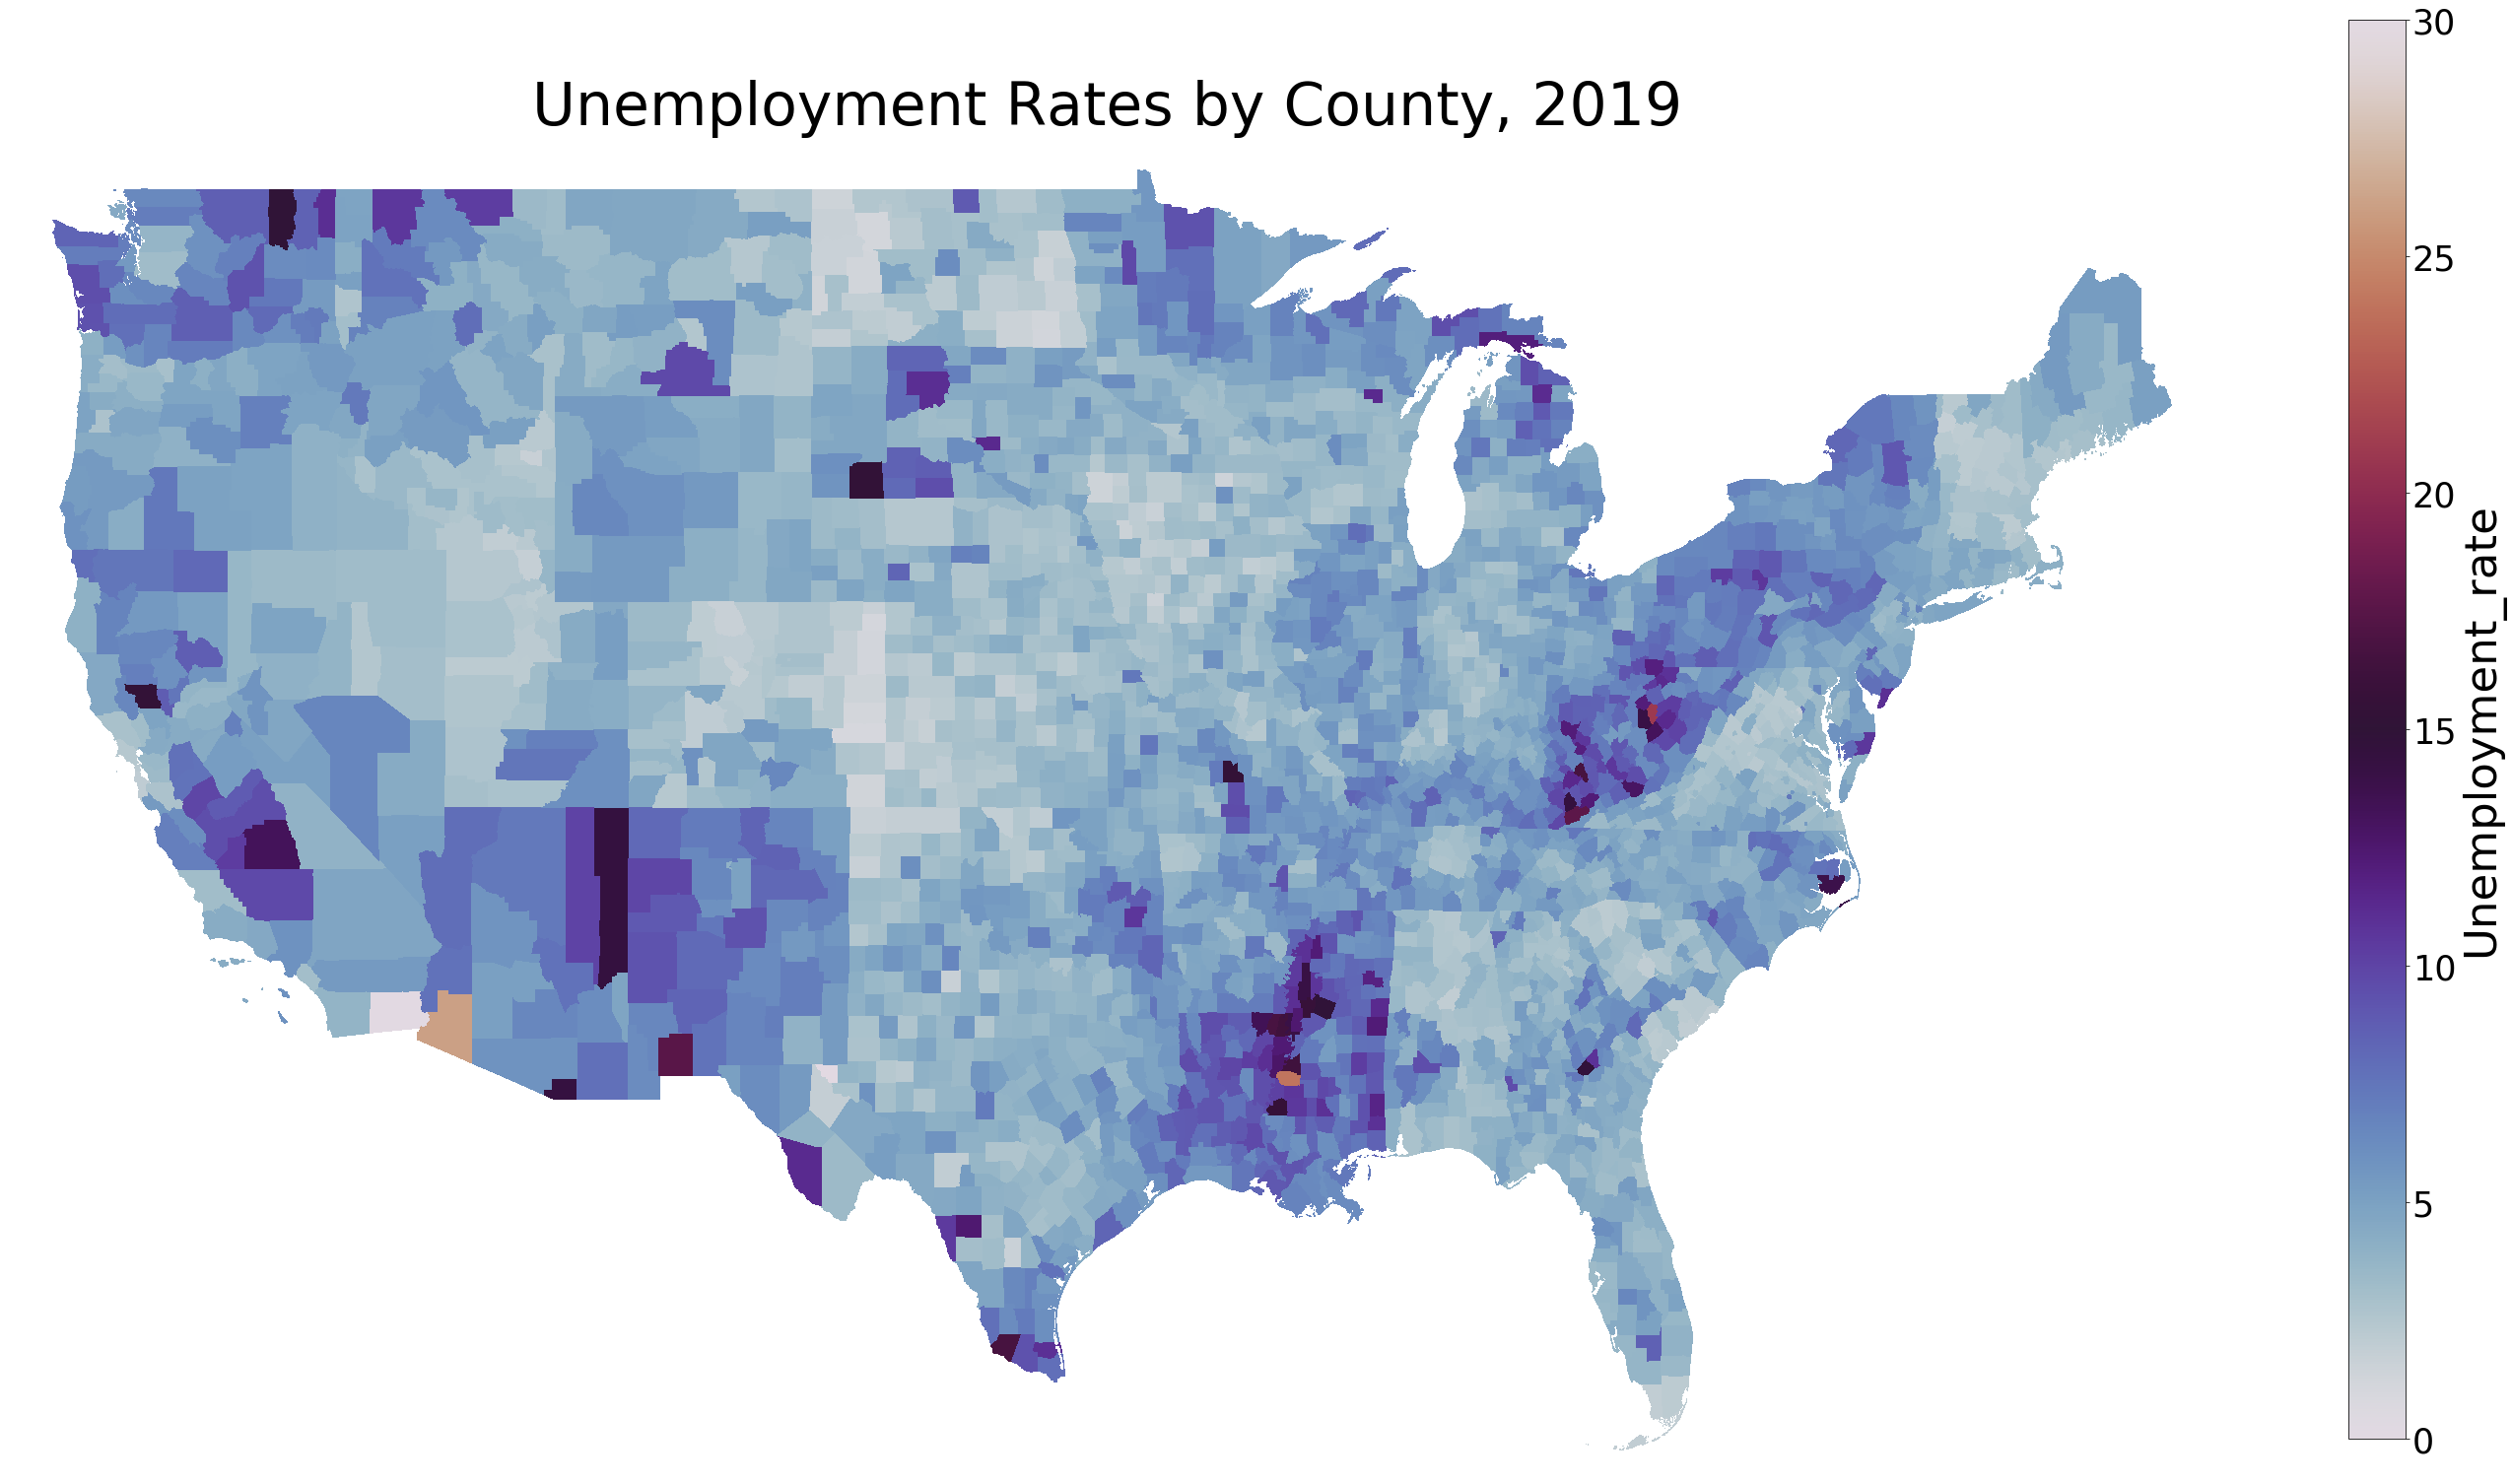

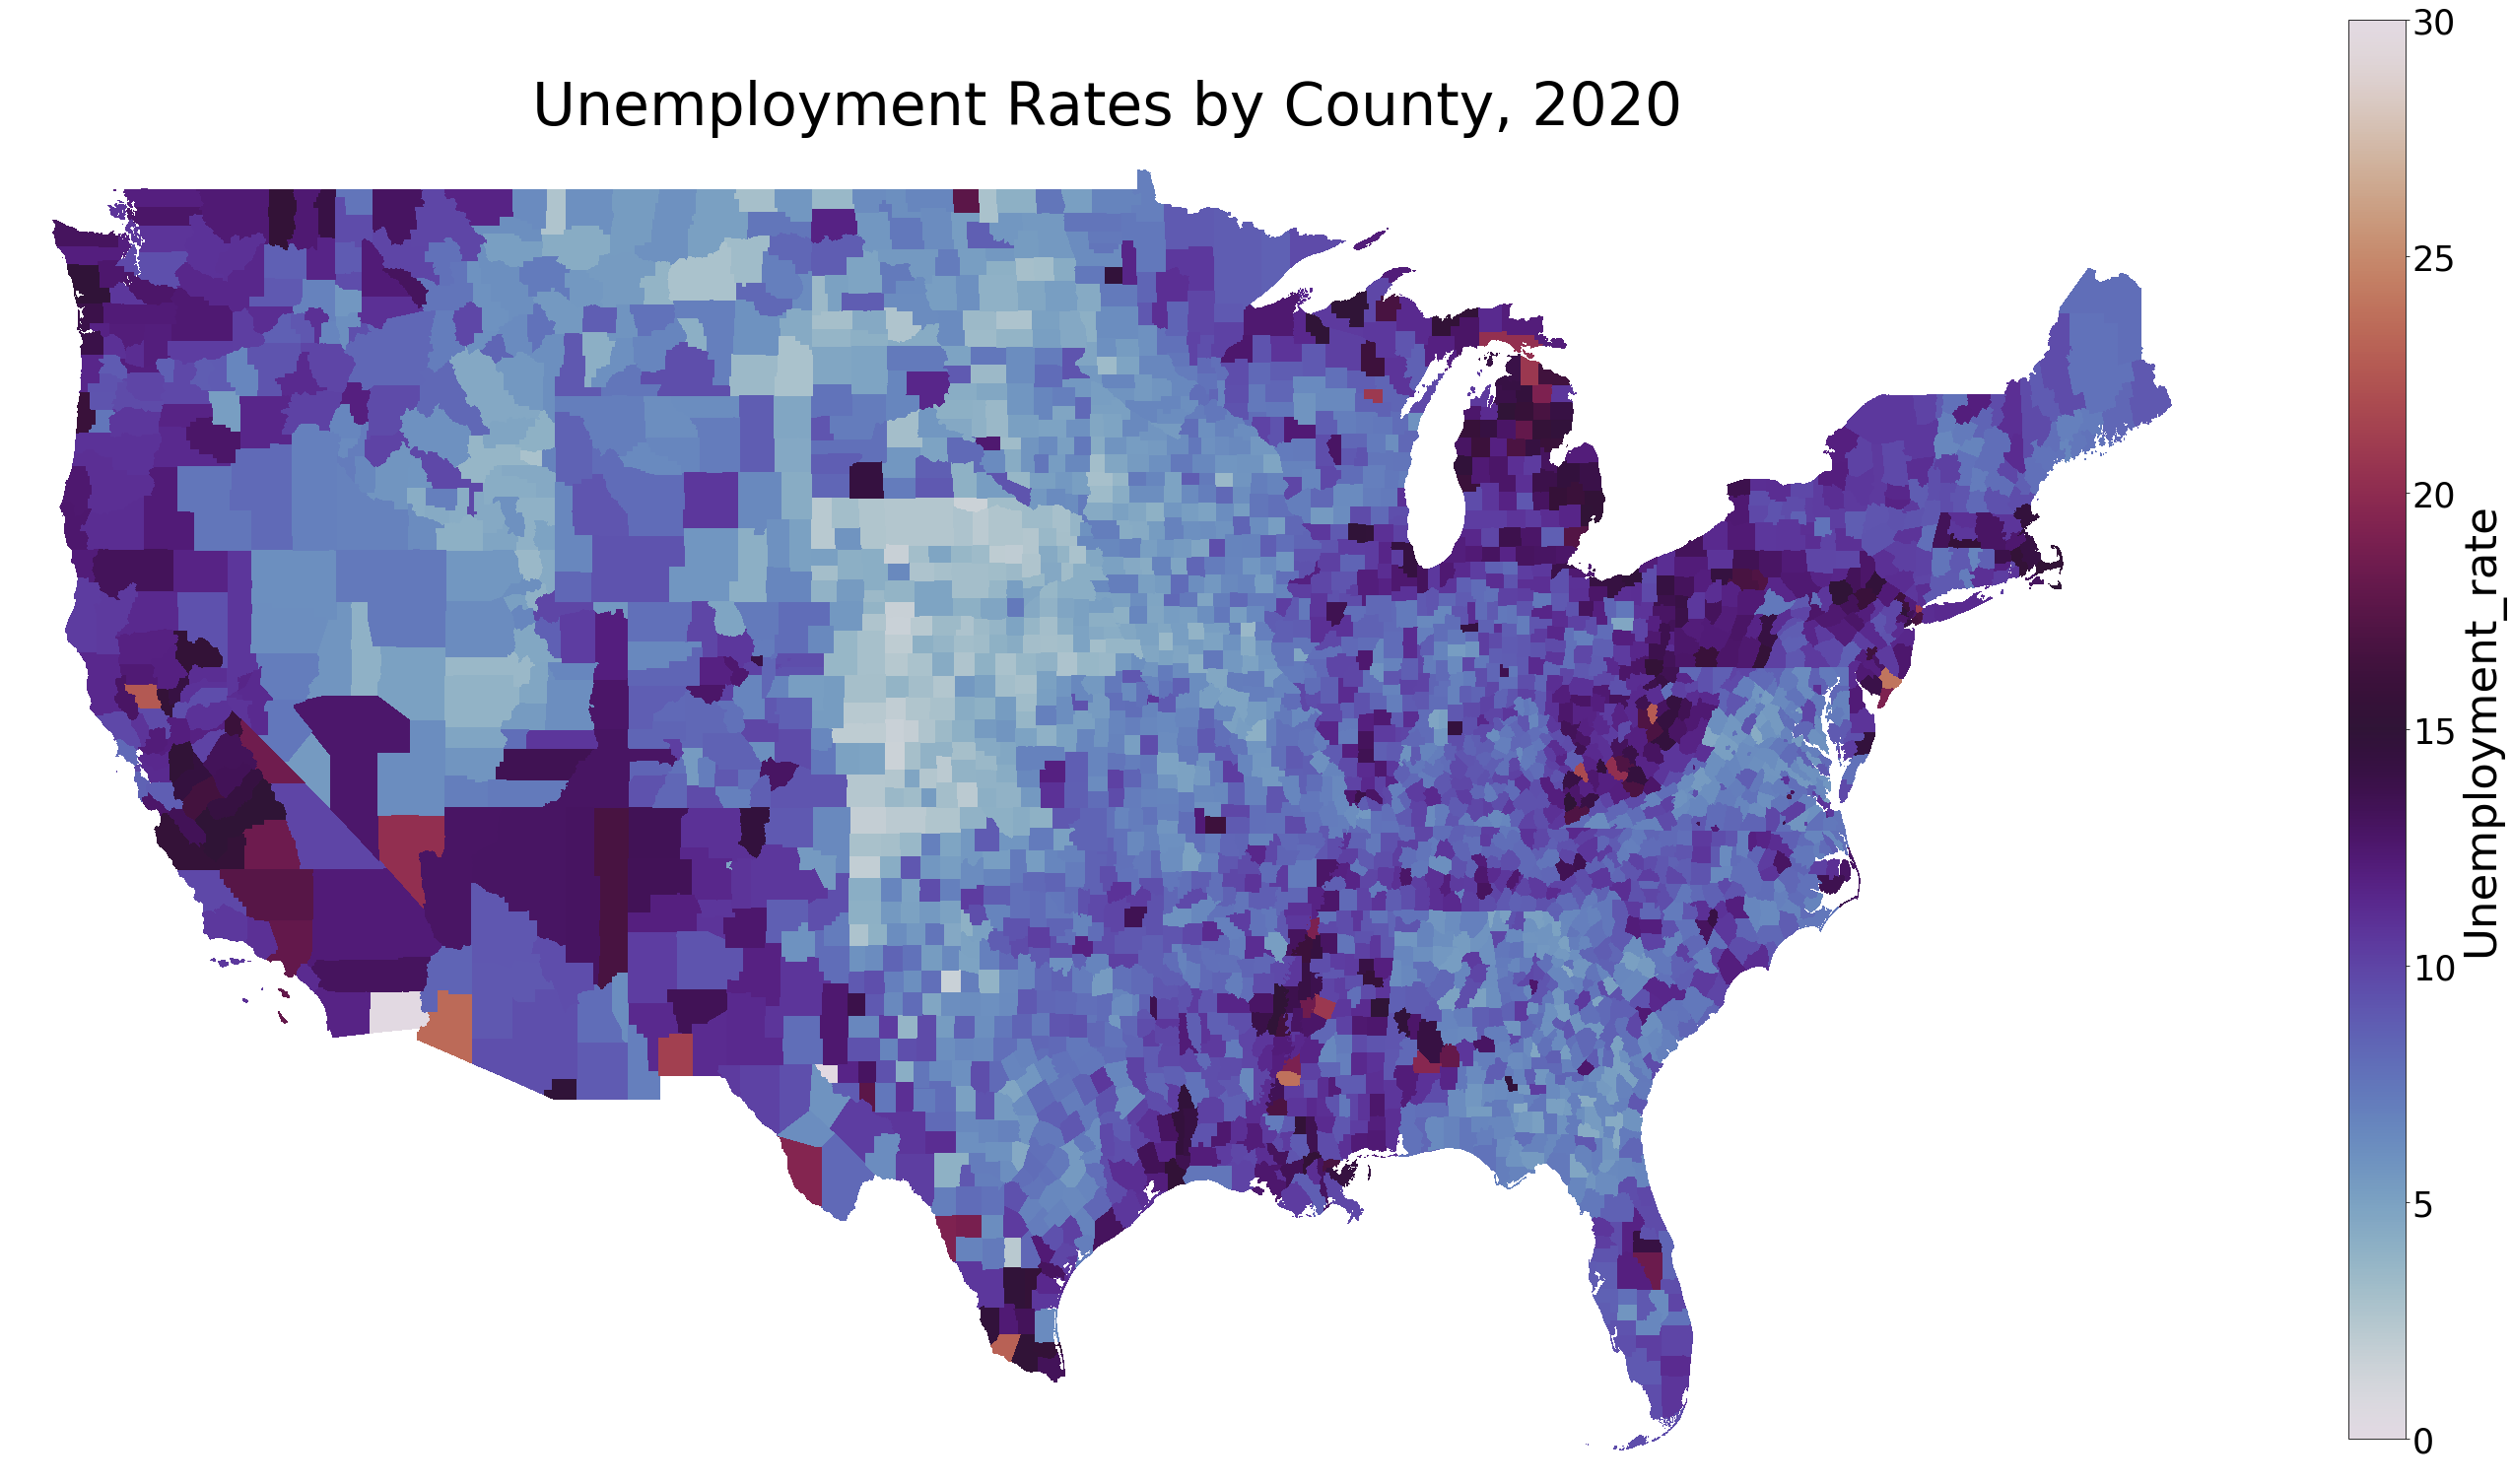

In [16]:
choropleth(df, 'Unemployment_rate', '2019', 'twilight', title='Unemployment Rates by County')
choropleth(df, 'Unemployment_rate', '2020', 'twilight', title='Unemployment Rates by County')

Unemployment rates were at low in 2019 before the pandemic started, and shot up significantly in 2020, as can be seen by the maps above, which show a large increase in unemployment rates across the country, and especially on the coasts.
### PoC Population Percentage by County, 2010 and 2018
These maps aim to visualize which areas of the country whose populations are predominantly people of color.

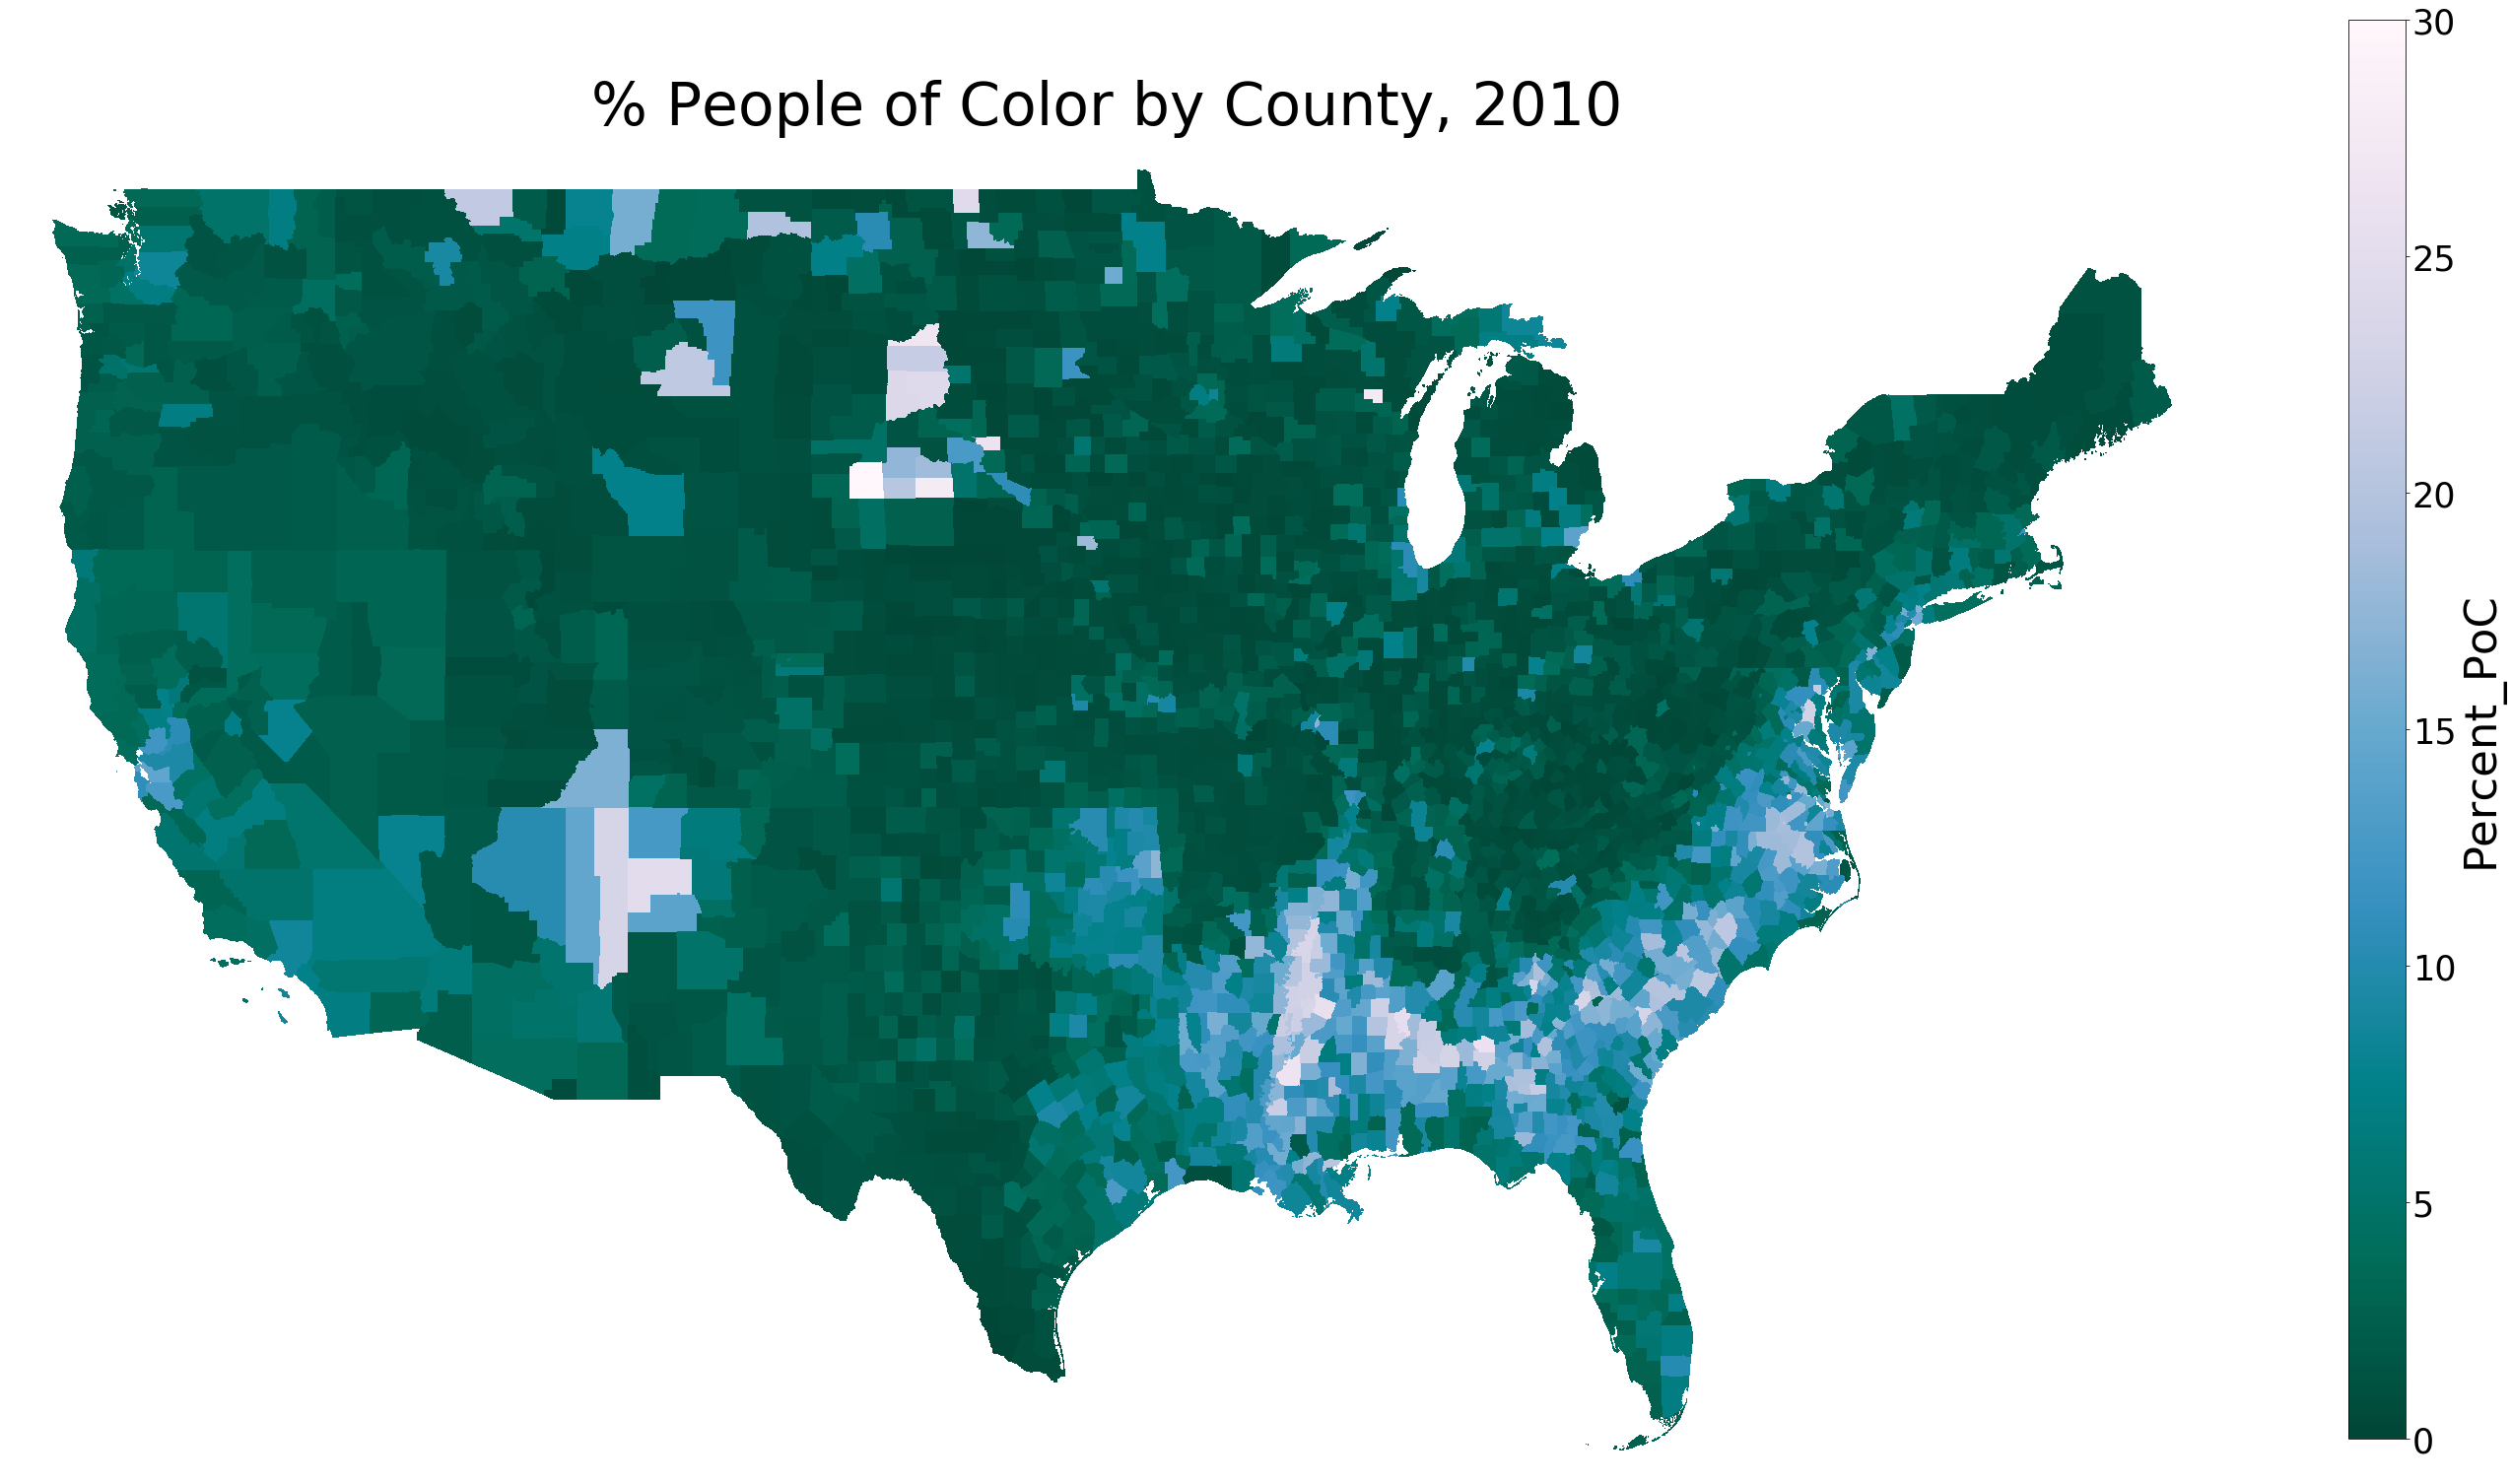

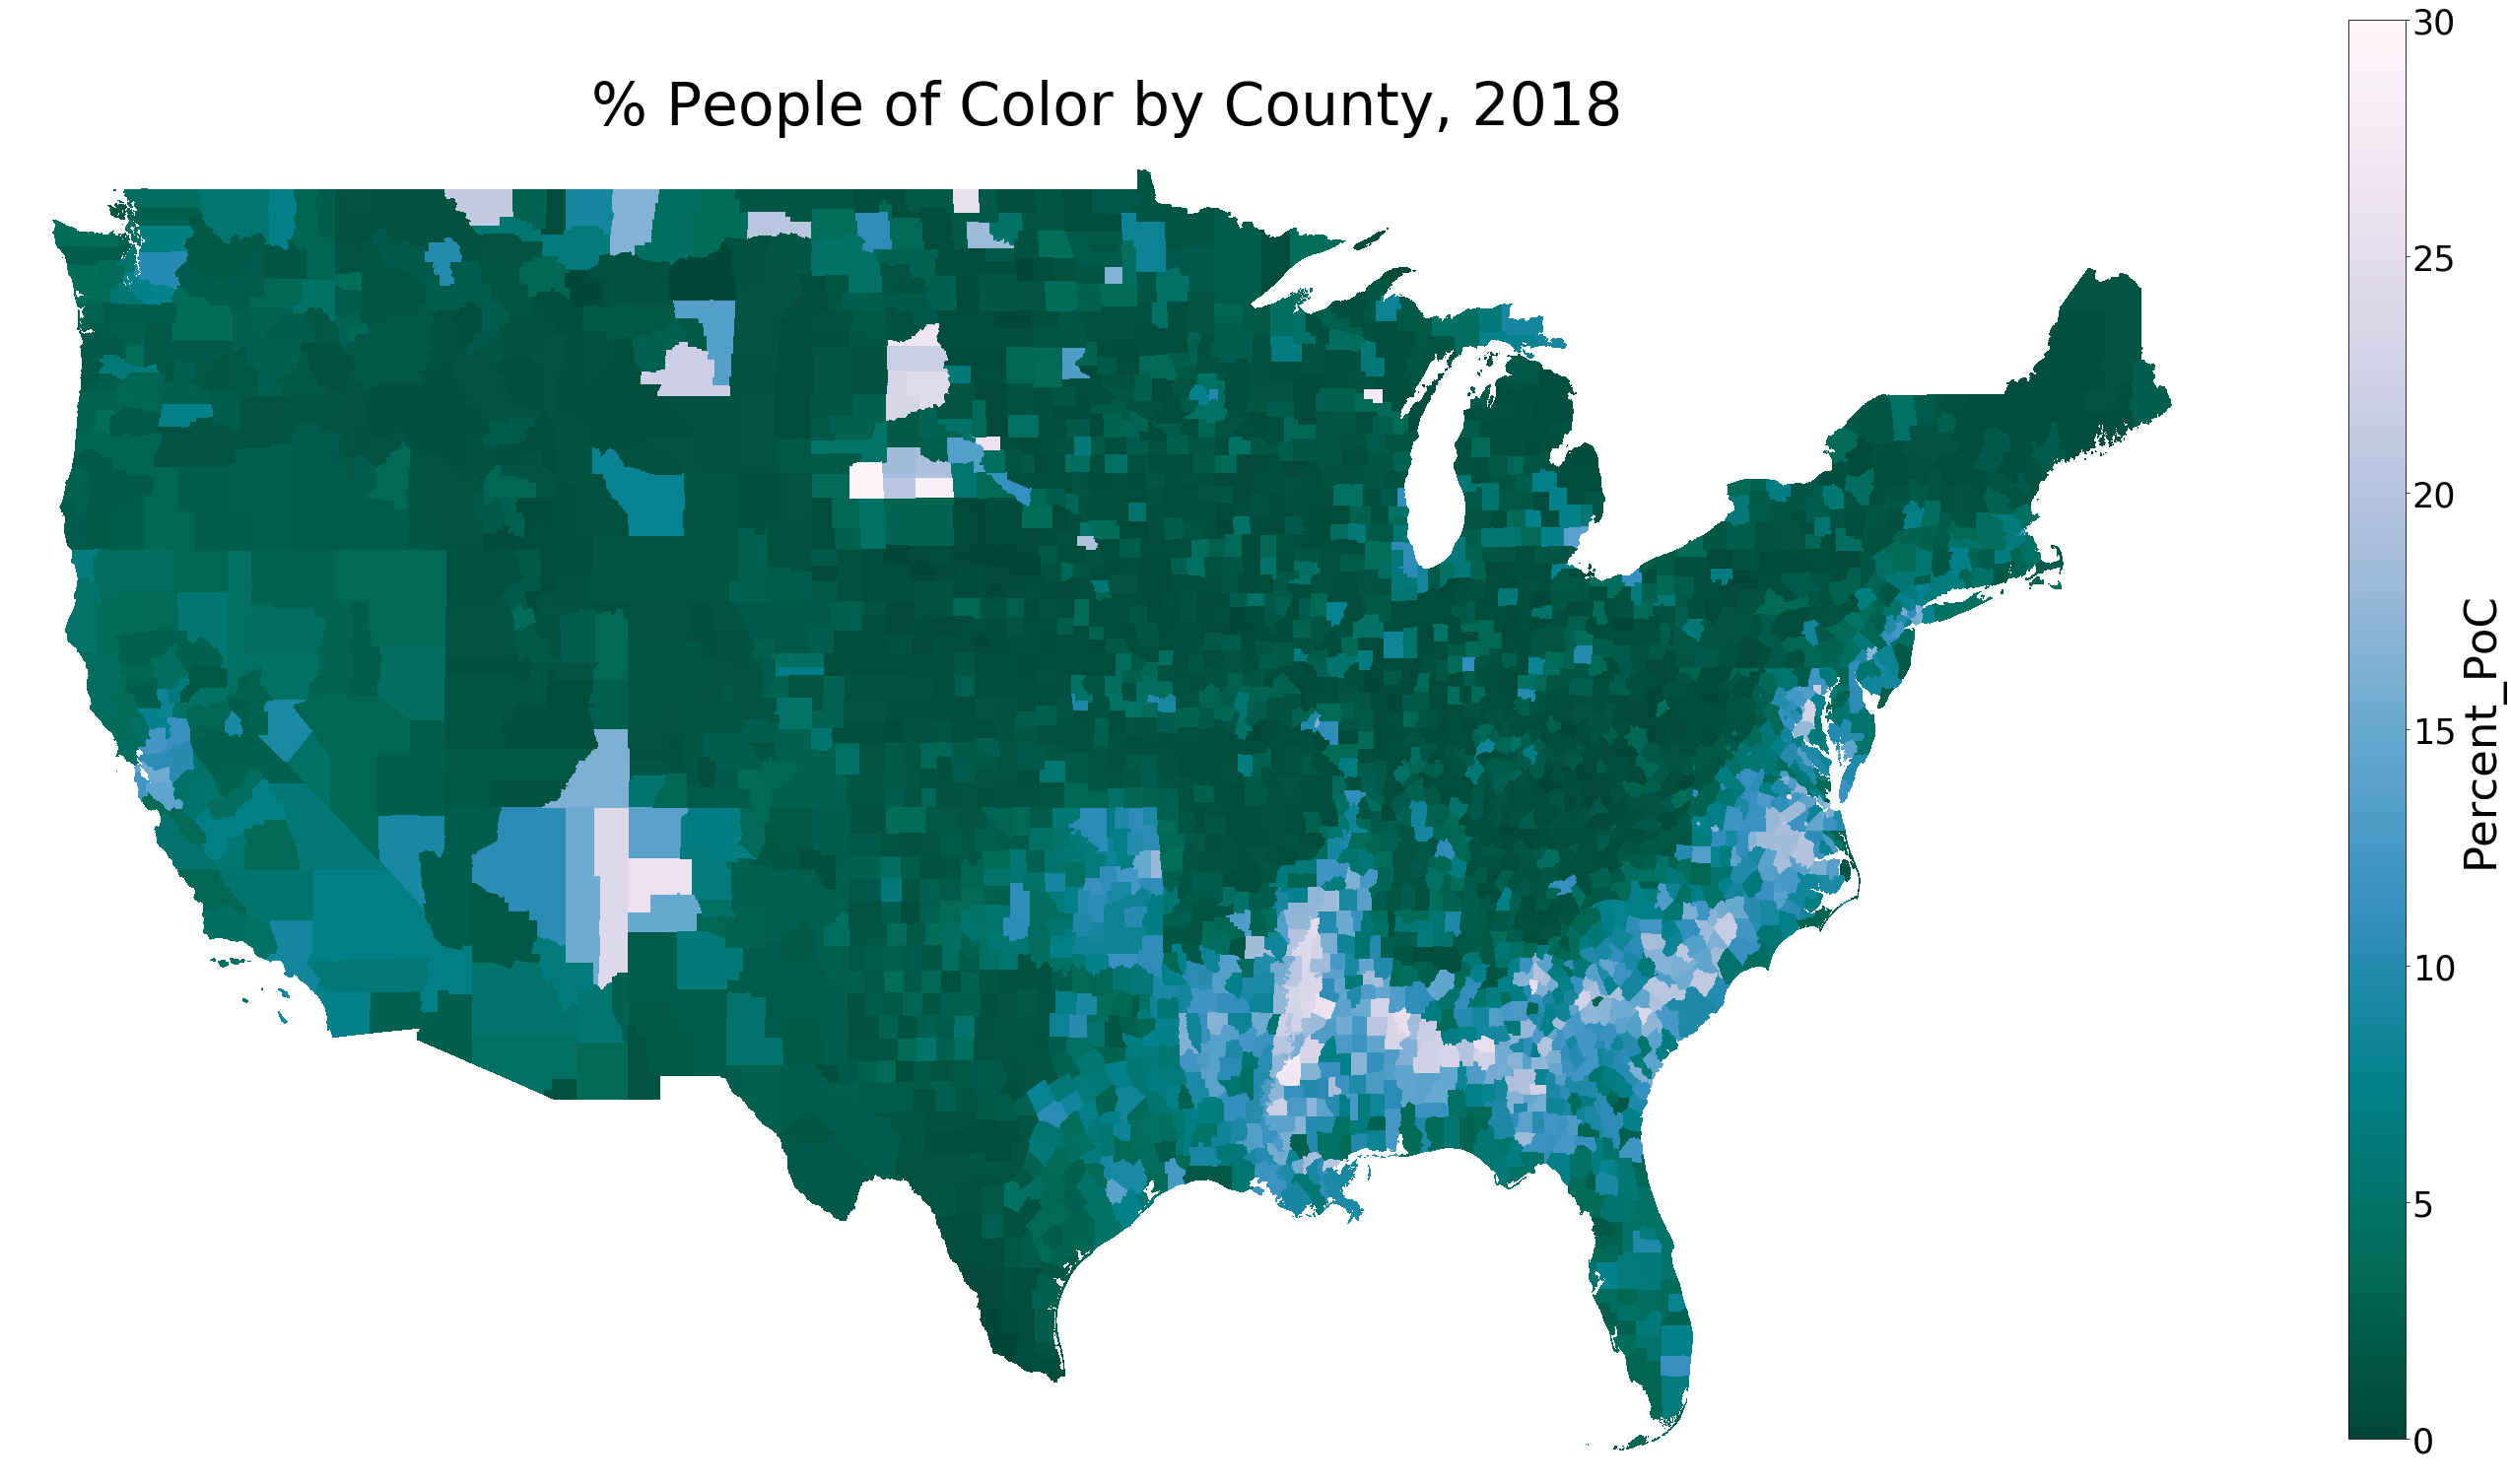

In [17]:
choropleth(df, 'Percent_PoC', '2010', 'PuBuGn_r', '% People of Color by County')
choropleth(df, 'Percent_PoC', '2018', 'PuBuGn_r', '% People of Color by County')

The above maps indicate that while the majority of US counties are predominantly white, there are significant areas, such as much of the southern states and portions of the Southwest that are predominantly communities of Color. There does not seem to be a significant change in this demographic spread between 2010 and 2018.
### Food Insecurity Rates by County, 2009 and 2018
The following maps visualize FI Rates by county in 2009 and 2018.

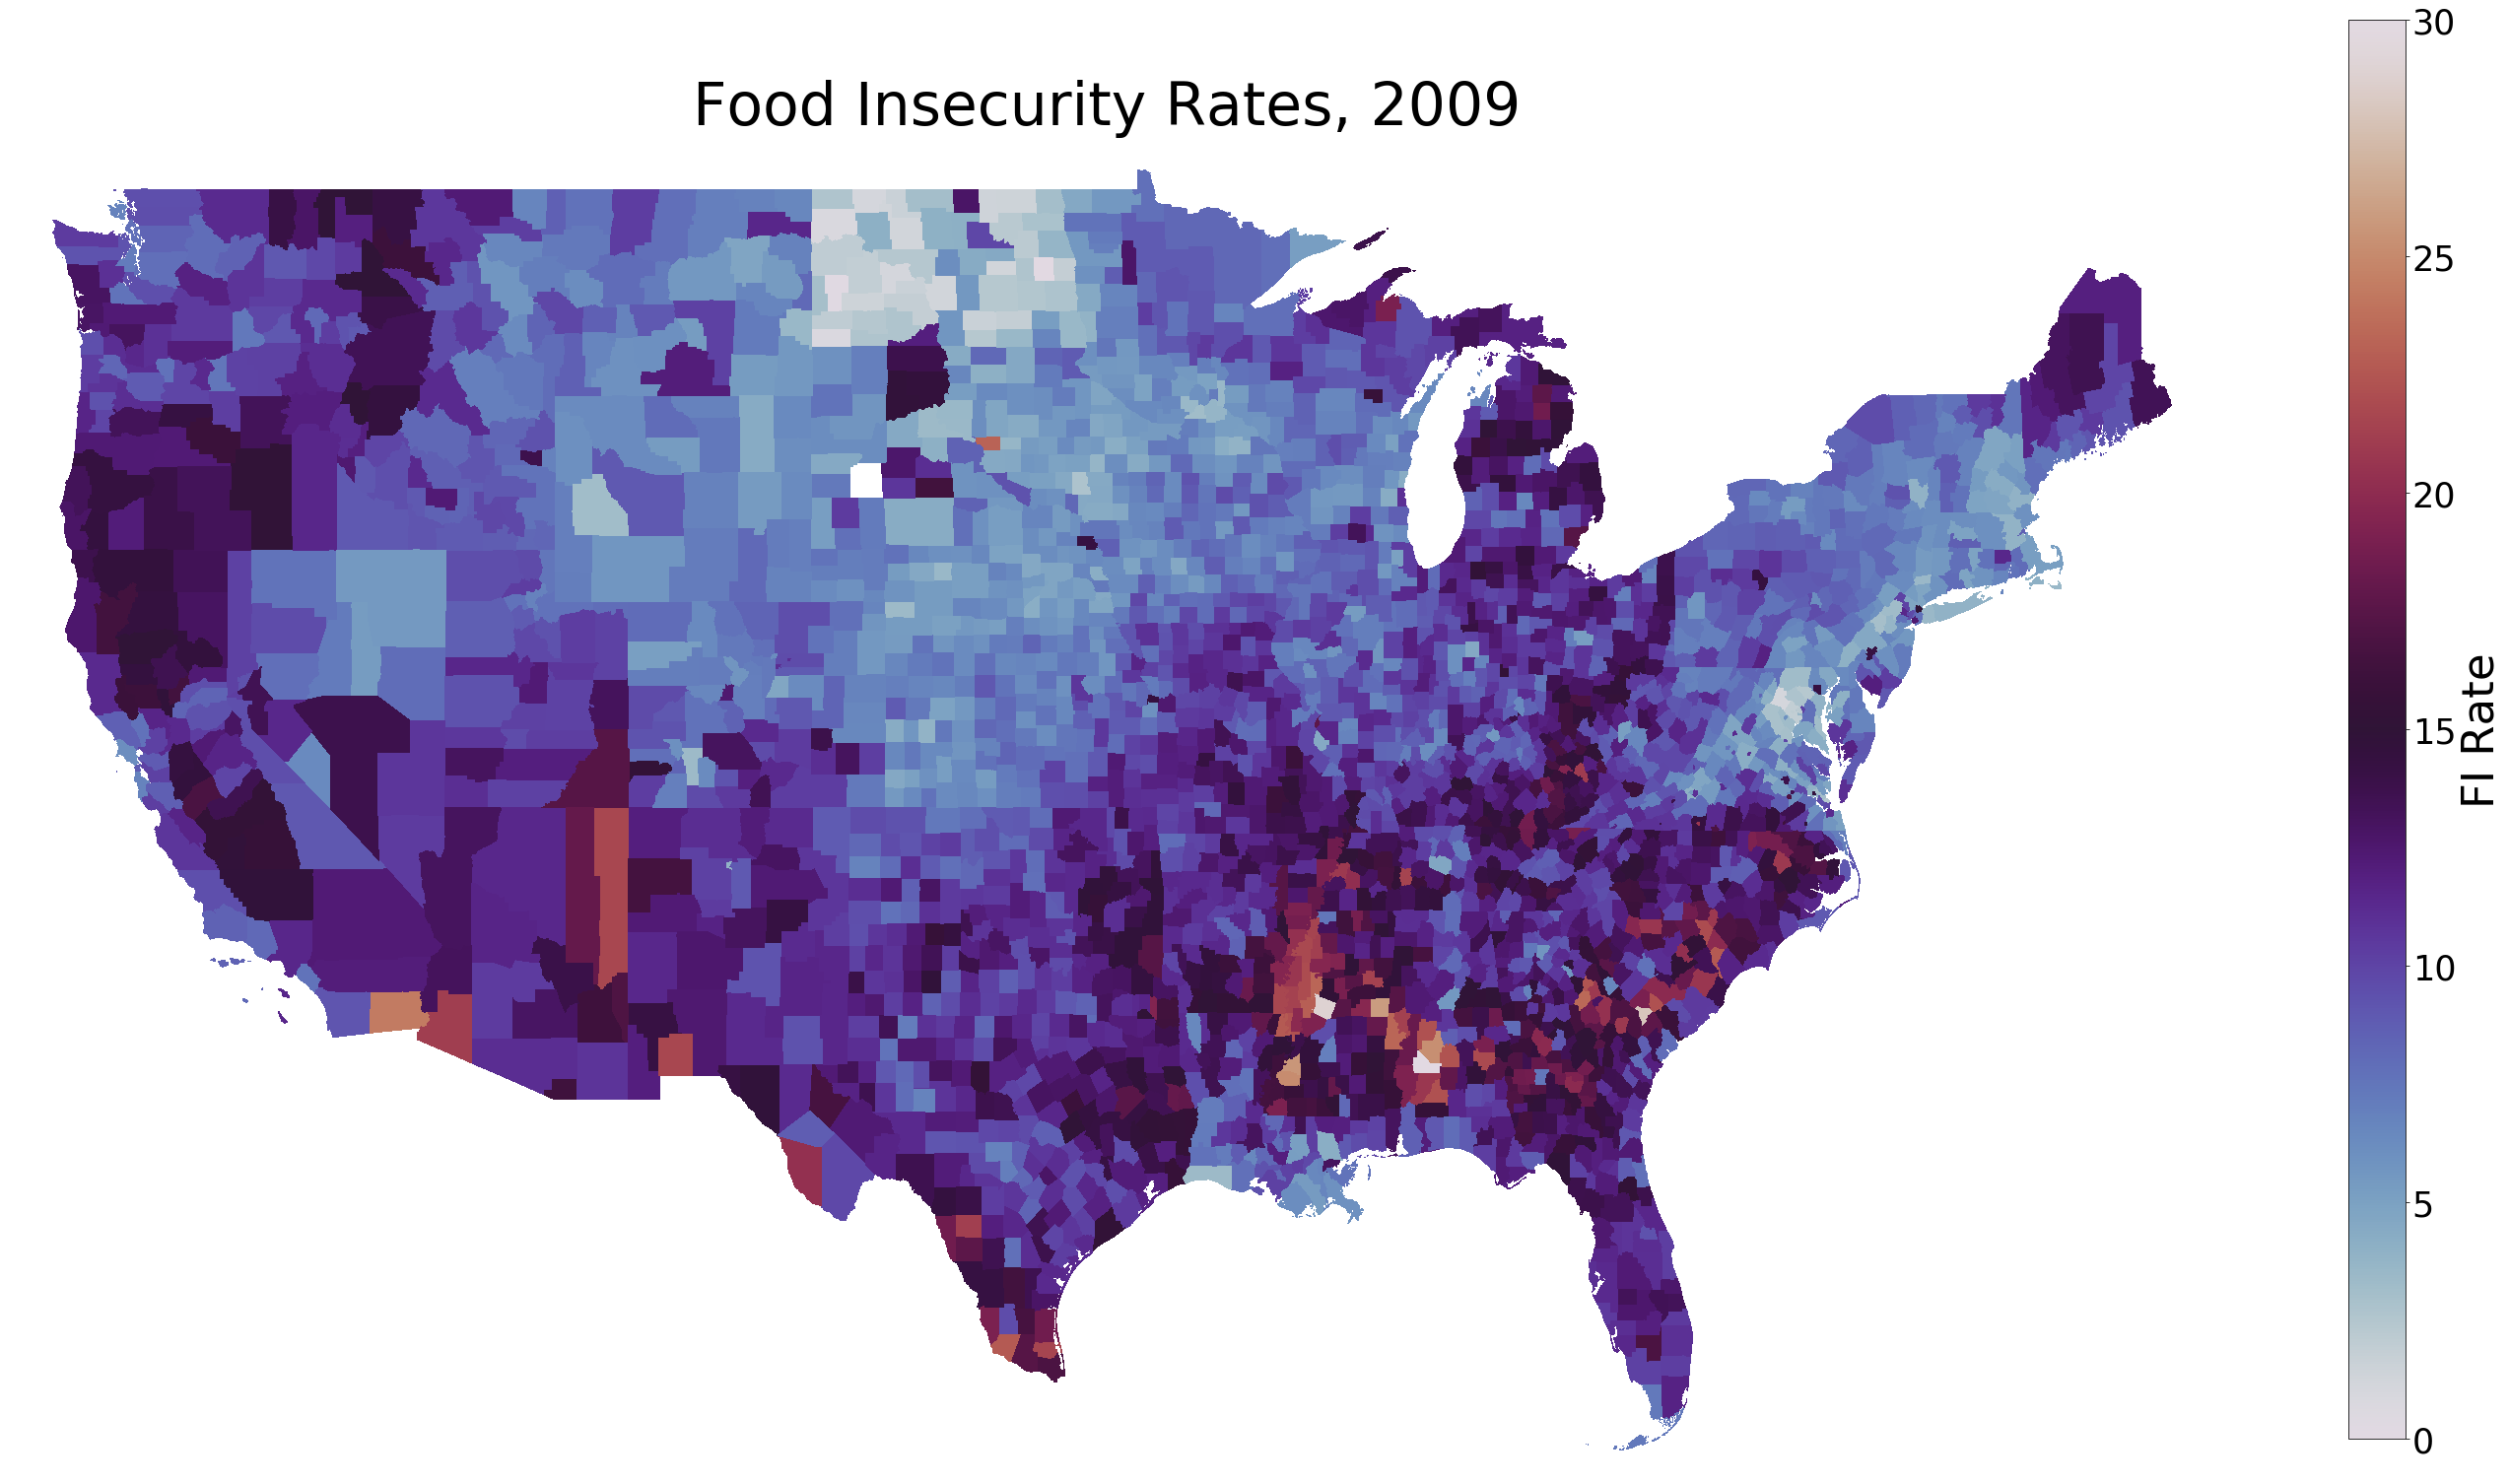

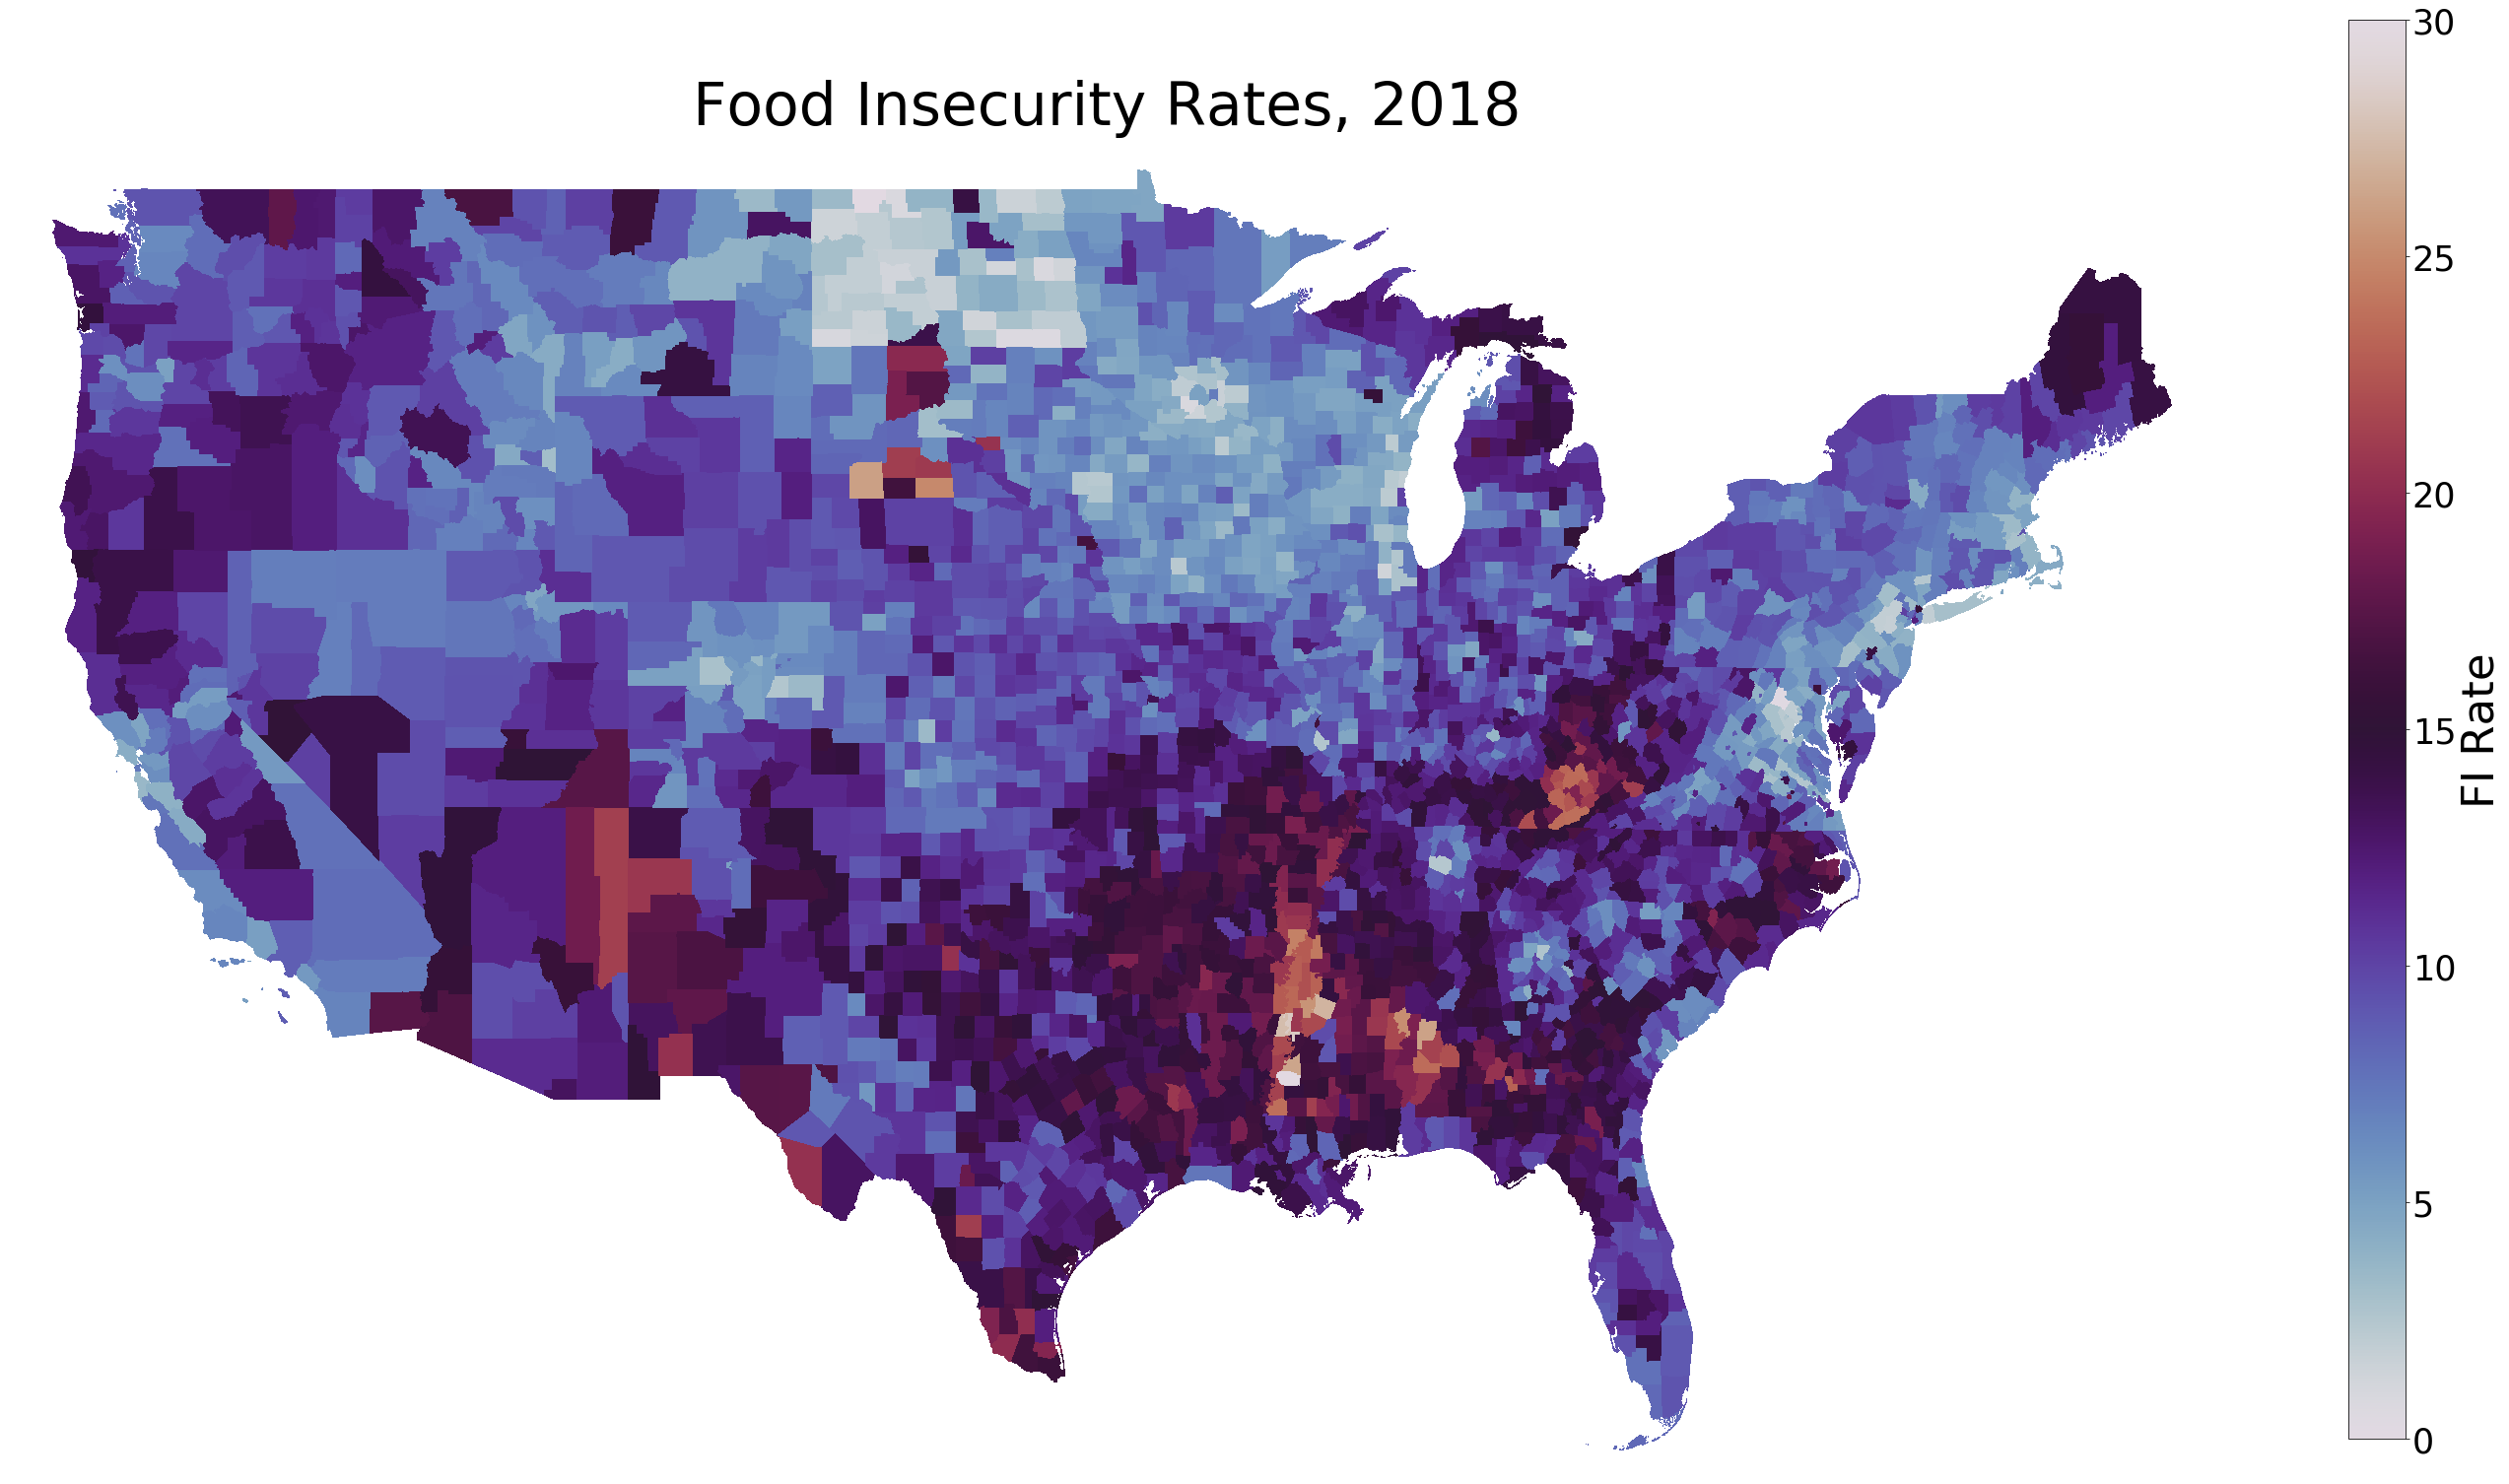

In [18]:
choropleth(df, 'FI Rate', '2009', 'twilight', 'Food Insecurity Rates')
choropleth(df, 'FI Rate', '2018', 'twilight', 'Food Insecurity Rates')

The maps above indicate lower average food insecurity rates over time in some areas, such as the Pacific Northwest, and significantly higher rates in Southern counties. This is important to note, given that national averages for FI rates have gone down over time, yet these maps indicate that in some communities, this problem has actually been exacerbated over time.<br>
More notably, when compared to the maps above, it should be noted that areas most effected by food insecurity very closely map to areas that are predominantly non-white.

# Question 3: How does food insecurity rate relate to each of the other features?
The purpose of this final EDA question is to determine how the other features in the dataset, such as Food Retail presence and Houselessness, relate to food insecurity rates. These observations will be important to keep in mind moving into the modeling process and looking at coefficients/feature importances.
### FI Distributions, by Restaraunt Count
The below histogram looks at the distribution of FI rates in areas with a restaraunt count over 600, vs under. 600 is used because it is the mean number of restaraunts in the dataset.

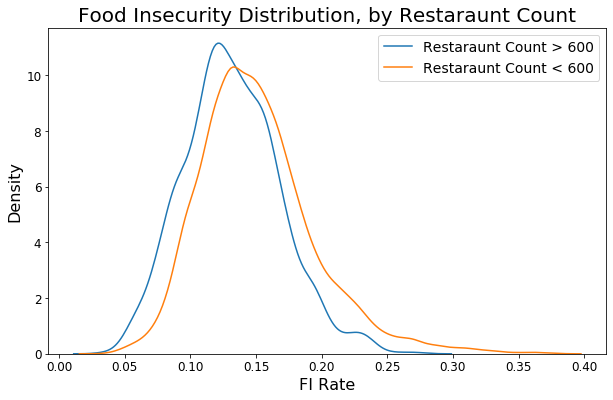

In [19]:
plt.figure(figsize=(10, 6));
ax = sns.distplot(df['FI Rate'][df['Num_restaraunts'] >df['Num_restaraunts'].mean()], label= 'Restaraunt Count > 600', hist=False);
ax = sns.distplot(df['FI Rate'][df['Num_restaraunts'] < df['Num_restaraunts'].mean()], label= 'Restaraunt Count < 600', hist=False);
ax.legend(prop=dict(size=14));
ax.set_title('Food Insecurity Distribution, by Restaraunt Count', fontsize=20);
ax.set_ylabel('Density', fontsize=16);
ax.set_xlabel('FI Rate', fontsize=16);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.savefig('../images/hist_fi_restar.png',format = 'png',bbox_inches='tight', transparent=True)

The above histogram shows slightly higher food insecurity rates in areas of lower restaraunt count, and slightly lower FI rate in areas of high restaraunt count. This could indicate that areas with more restaraunt presence generally have slighly lower FI rate.
### FI Distribution, by Rent Prices
The below histograms show the distribution of FI rates in areas with 1-br apartment rent prices above $ 2000, vs areas with rent prices below $1000.

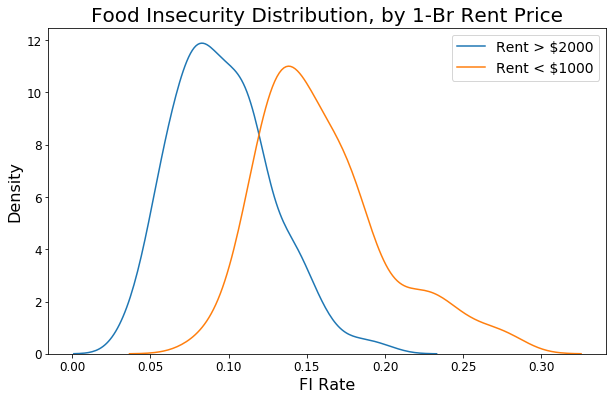

In [20]:
plt.figure(figsize=(10, 6));
ax = sns.distplot(df['FI Rate'][df['Rent'] >2000], label= 'Rent > $2000', hist=False);
ax = sns.distplot(df['FI Rate'][df['Rent'] < 1000], label= 'Rent < $1000', hist=False);
ax.legend(prop=dict(size=14));
ax.set_title('Food Insecurity Distribution, by 1-Br Rent Price', fontsize=20);
ax.set_ylabel('Density', fontsize=16);
ax.set_xlabel('FI Rate', fontsize=16);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.savefig('../images/hist_fi_rent.png',format = 'png',bbox_inches='tight', transparent=True)

The above histograms indicate a visually significant difference between the two. Areas with lower rent prices have generally higher FI Rates, while areas with higher rent prices have lower FI Rates. This makes sense, given that "wealthier" areas likely less from food insecurity.
### FI Rate Distributions, by Unemployment Rate
The following histograms plot FI rate distribution, by areas with unemployment rates above %15, vs areas with unemployment rates below %5.

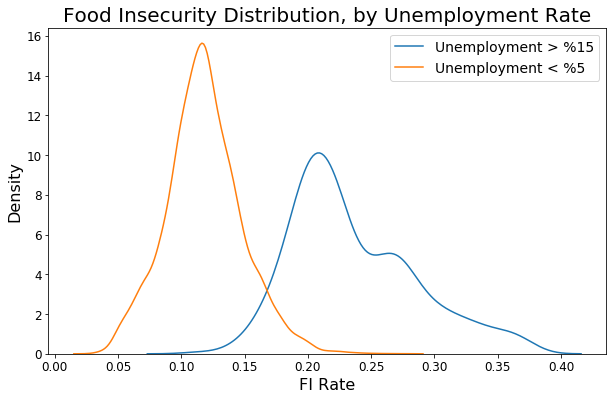

In [21]:
plt.figure(figsize=(10, 6));
ax = sns.distplot(df['FI Rate'][df['Unemployment_rate'] >15], label= 'Unemployment > %15', hist=False);
ax = sns.distplot(df['FI Rate'][df['Unemployment_rate'] < 5], label= 'Unemployment < %5', hist=False);
ax.legend(prop=dict(size=14));
ax.set_title('Food Insecurity Distribution, by Unemployment Rate', fontsize=20);
ax.set_ylabel('Density', fontsize=16);
ax.set_xlabel('FI Rate', fontsize=16);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.savefig('../images/hist_fi_unemp.png',format = 'png',bbox_inches='tight', transparent=True)

The above historams show a visually significant difference in FI rates between areas based on unemployment rates. Areas with high unemployment rates have higher average FI Rates, while areas with low unemployment rates have lower average FI Rates. This is pretty intuitive, given that being unemployed is a likely cause of being unable to afford food.
### FI Distributions, by Houseless Rates
The below histograms plot food insecurity distributions of areas with a houseless rate above %1, and areas with a houseless rate below %0.01.

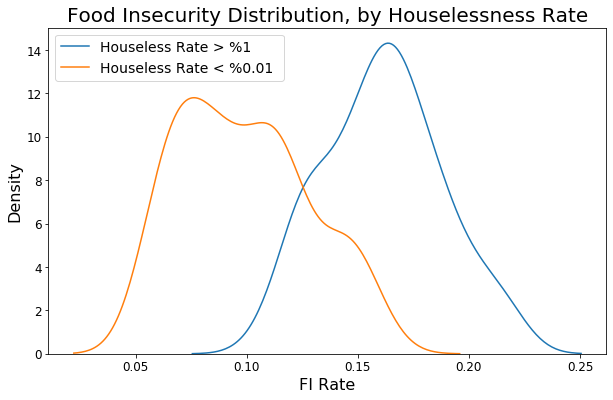

In [22]:
plt.figure(figsize=(10, 6));
ax = sns.distplot(df['FI Rate'][df['Houseless_rate'] >.01], label= 'Houseless Rate > %1', hist=False);
ax = sns.distplot(df['FI Rate'][df['Houseless_rate'] < .0001], label= 'Houseless Rate < %0.01 ', hist=False);
ax.legend(prop=dict(size=14));
ax.set_title('Food Insecurity Distribution, by Houselessness Rate', fontsize=20);
ax.set_ylabel('Density', fontsize=16);
ax.set_xlabel('FI Rate', fontsize=16);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
# plt.savefig('../images/hist_fi_houseless.png',format = 'png',bbox_inches='tight', transparent=True)

The above histograms indicate a visually significant difference between the two distributions. Areas with higher houselessness rates have a higher average FI Rate than areas with low houselessness. This makes sense, given that being houseless possibly indicates a lack of money, which lacks to an inability to buy enough food.
### FI Rate Distribution, by Race
The following histograms plot food insecurity rate distributions for areas of predominently different races.

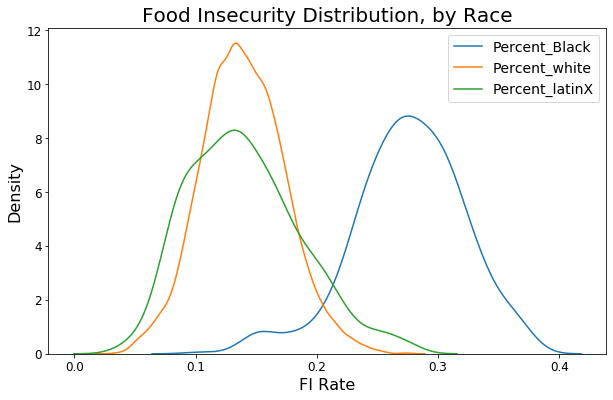

In [23]:
plt.figure(figsize=(10, 6));
for feat in ['Percent_Black', 'Percent_white', 'Percent_latinX']:
    ax = sns.distplot(df['FI Rate'][df[feat] > .6], label= feat, hist=False);
ax.legend(prop=dict(size=14));
ax.set_title('Food Insecurity Distribution, by Race', fontsize=20);
ax.set_ylabel('Density', fontsize=16);
ax.set_xlabel('FI Rate', fontsize=16);

plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
# plt.savefig('../images/hist_fi_race.png',format = 'png',bbox_inches='tight', transparent=True)

The above histograms indicate a visually significant different in FI rates for different racial communities. Areas that are predominently Black are shown to have a much higher average FI rate than predominantly white or LatinX communities. This is important to keep in mind, when considering feature importance and factors that are significant indicators for food insecurity.
### Average Food Insecurity Rate, by Race
The following cell displays mean FI rates in different racial communities, where the population of one race is above 50%:

In [24]:
print('Average FI Rate in Predominently Black Communities:',df['FI Rate'][df['Percent_Black']>.5].mean())
print('Average FI Rate in Predominently PoC Communities:',df['FI Rate'][df['Percent_PoC']>.5].mean())
print('Average FI Rate in Predominently White Communities:',df['FI Rate'][df['Percent_white']>.5].mean())


Average FI Rate in Predominently Black Communities: 0.2517524653544353
Average FI Rate in Predominently PoC Communities: 0.2251573112521035
Average FI Rate in Predominently White Communities: 0.14147558596680776


The above code indicates a significantly higher average FI rate among Black communities, and all communities of color.
### FI Rate Scatter Plots
The below cell generates scatter plots comparing FI Rates to unemployment, rent, and percentage white/Black

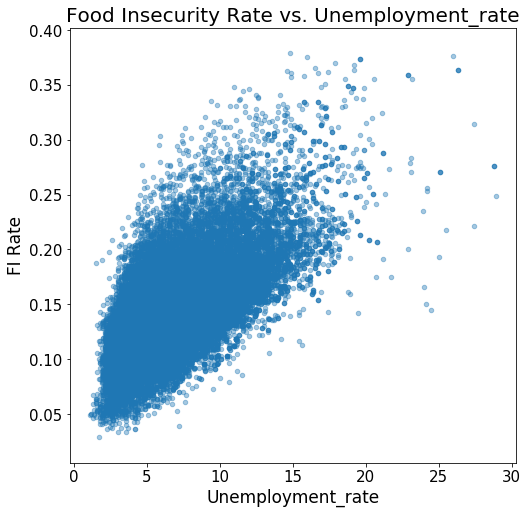

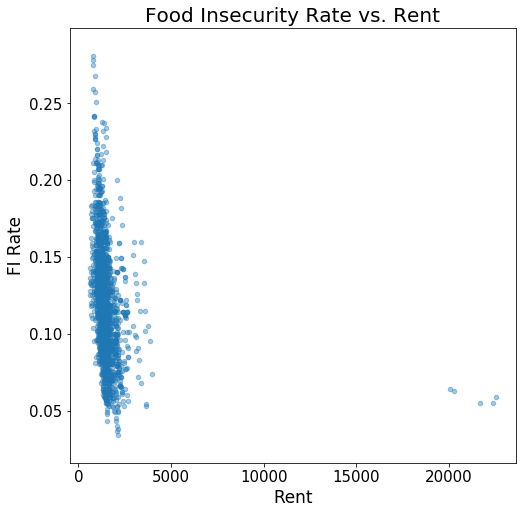

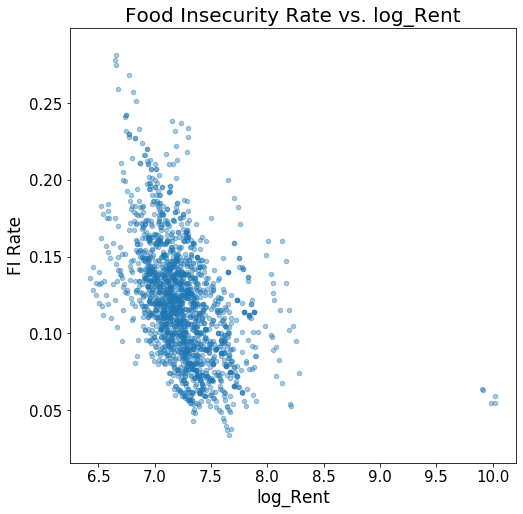

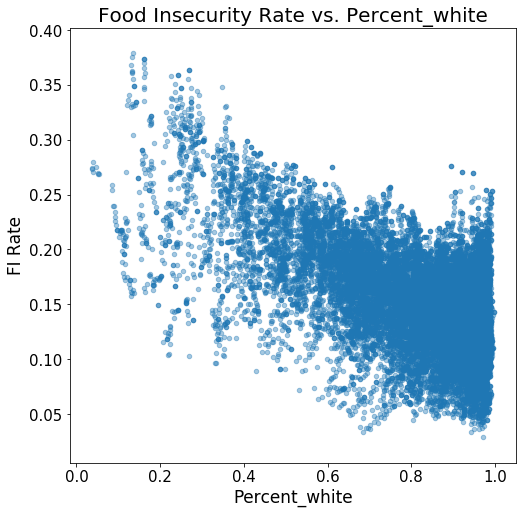

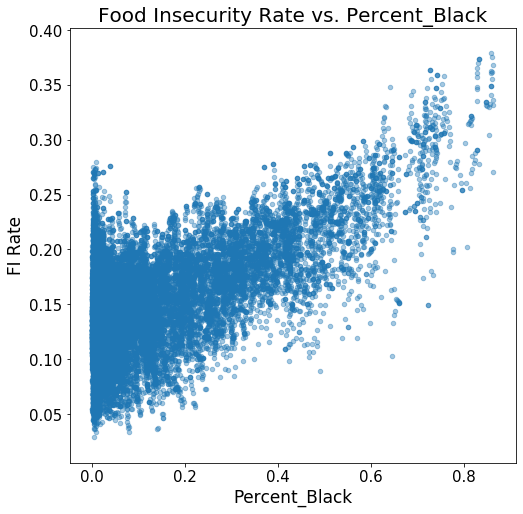

In [25]:
# iterate through each feature of interest, and create scatter plot with FI Rate on Y axis
features = [ 'Unemployment_rate','Rent','log_Rent', 'Percent_white','Percent_Black']
for feat in features:
    ax = df.plot(kind='scatter', x=feat, y='FI Rate',  alpha=0.4,figsize=(8, 8));
    plt.xticks(fontsize=15);
    plt.yticks(fontsize=15);
    ax.set_title('Food Insecurity Rate vs. '+feat, fontsize=20);
    ax.set_ylabel('FI Rate', fontsize=17);
    ax.set_xlabel(feat, fontsize=17);
#     plt.savefig('../images/scatter_'+feat+'.png',format = 'png',bbox_inches='tight', transparent=True)
    

The above plots visually indicate a positive correlation between FI rate vs unemployment rate, and FI rate vs percentage Black. They indicate a negative correlation between FI rate vs rent price, and FI rate vs. percentage white.
# Conclusion
This data analysis explores the following questions through the lens of time and geography:

1. How have metrics such as unemployment, houselessness, and food insecurity rates changed over time?
2. How do unemployment, race, and food insecurity rates vary geographically?
3. What is the relationship between food insecurity rate and other factors such as rent prices, unemployment, houselessness, and race?

From the analysis, we see close relationships between FI Rates, unemployment rates, houseless rates, and race, both in terms of which areas are **geographically** impacted most, as well as how these different features have changed **over time**.
<br>Communities of color, particularly Black communities, as well as communities with high unemployment and houselessness are shown through this analysis to have the highest FI rates. In addition, while many features such as FI rate, unemployment, and houselessness have decreased over time *on average*, the above choropleth maps indicate that these factors have actually been *exacerbated* in certain geographic areas over time.<br><br>
**The findings of this data exploration are meaningful when determining which communities and geographic areas are most at-risk for high food insecurity rates, and should be used both in terms of allocating resources to these communities, as well as taking proactive measures to address the root cause of these issues that disproportionately affect certain communities over others.**